<a href="https://colab.research.google.com/github/EmanueleCosenza/Polyphemus/blob/main/midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pwd

/home/cosenza/thesis/Polyphemus


In [2]:
!git branch

  main
* sparse


Libraries installation

In [3]:
#!tar -C data -xvzf data/lmd_matched.tar.gz

In [4]:
# Install the required music libraries
#!pip3 install muspy
#!pip3 install pypianoroll

In [5]:
# Install torch_geometric
#!v=$(python3 -c "import torch; print(torch.__version__)"); \
#pip3 install torch-scatter -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-sparse -f https://data.pyg.org/whl/torch-${v}.html; \
#pip3 install torch-geometric

Reproducibility

In [6]:
import numpy as np
import torch
import random
import os

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42
set_seed(seed)

In [7]:
import os
import muspy
from itertools import product
import pypianoroll as pproll
import time
from tqdm.auto import tqdm


class MIDIPreprocessor():
    
    def __init__():
        pass

    def preprocess_dataset(self, dir, early_exit=None):
        pass
    
    def preprocess_file(self, f):
        pass


# Todo: to config file (or separate files)
MAX_SIMU_NOTES = 16 # 14 + SOS and EOS

PITCH_SOS = 128
PITCH_EOS = 129
PITCH_PAD = 130
DUR_PAD_IND = 2
MAX_DUR = 511 # equivalent to 16 bars (with RESOLUTION=8)

# Number of time steps per quarter note
# To get bar resolution -> RESOLUTION*4
RESOLUTION = 8 
NUM_BARS = 1


def preprocess_file(filepath, dest_dir, num_samples):

    saved_samples = 0

    print("Preprocessing file " + filepath)

    # Load the file both as a pypianoroll song and a muspy song
    # (Need to load both since muspy.to_pypianoroll() is expensive)
    try:
        pproll_song = pproll.read(filepath, resolution=RESOLUTION)
        muspy_song = muspy.read(filepath)
    except Exception as e:
        print("Song skipped (Invalid song format)")
        return 0
    
    # Only accept songs that have a time signature of 4/4 and no time changes
    for t in muspy_song.time_signatures:
        if t.numerator != 4 or t.denominator != 4:
            print("Song skipped ({}/{} time signature)".
                            format(t.numerator, t.denominator))
            return 0

    # Gather tracks of pypianoroll song based on MIDI program number
    drum_tracks = []
    bass_tracks = []
    guitar_tracks = []
    strings_tracks = []

    for track in pproll_song.tracks:
        if track.is_drum:
            track.name = 'Drums'
            drum_tracks.append(track)
        elif 0 <= track.program <= 31:
            track.name = 'Guitar'
            guitar_tracks.append(track)
        elif 32 <= track.program <= 39:
            track.name = 'Bass'
            bass_tracks.append(track)
        else:
            # Tracks with program > 39 are all considered as strings tracks
            # and will be merged into a single track later on
            strings_tracks.append(track)

    # Filter song if it does not contain drum, guitar, bass or strings tracks
    if not drum_tracks or not guitar_tracks \
       or not bass_tracks or not strings_tracks:
        print("Song skipped (does not contain drum or "
                "guitar or bass or strings tracks)")
        return 0
    
    # Merge strings tracks into a single pypianoroll track
    strings = pproll.Multitrack(tracks=strings_tracks)
    strings_track = pproll.Track(pianoroll=strings.blend(mode='max'),
                                 program=48, name='Strings')

    combinations = list(product(drum_tracks, bass_tracks, guitar_tracks))

    # Single instruments can have multiple tracks.
    # Consider all possible combinations of drum, bass, and guitar tracks
    for i, combination in enumerate(combinations):

        print("Processing combination", i+1, "of", len(combinations))
        
        # Process combination (called 'subsong' from now on)
        drum_track, bass_track, guitar_track = combination
        tracks = [drum_track, bass_track, guitar_track, strings_track]
        
        pproll_subsong = pproll.Multitrack(
            tracks=tracks,
            tempo=pproll_song.tempo,
            resolution=RESOLUTION
        )
        muspy_subsong = muspy.from_pypianoroll(pproll_subsong)
        
        tracks_notes = [track.notes for track in muspy_subsong.tracks]
        
        # Obtain length of subsong (maximum of each track's length)
        length = 0
        for notes in tracks_notes:
            track_length = max(note.end for note in notes) if notes else 0
            length = max(length, track_length)
        length += 1

        # Add timesteps until length is a multiple of RESOLUTION
        length = length if length%(RESOLUTION*4) == 0 \
                            else length + (RESOLUTION*4-(length%(RESOLUTION*4)))


        tracks_tensors = []
        tracks_activations = []

        dur_bin_length = int(np.ceil(np.log2(MAX_DUR)))

        # Todo: adapt to velocity
        for notes in tracks_notes:

            # Initialize encoder-ready track tensor
            # track_tensor: (length x max_simu_notes x 2 (or 3 if velocity))
            # The last dimension contains pitches and durations (and velocities)
            # int16 is enough for small to medium duration values
            track_tensor = np.zeros((length, MAX_SIMU_NOTES, 2), np.int16)

            track_tensor[:, :, 0] = PITCH_PAD
            track_tensor[:, 0, 0] = PITCH_SOS

            # Keeps track of how many notes have been stored in each timestep
            # (int8 imposes that MAX_SIMU_NOTES < 256)
            notes_counter = np.ones(length, dtype=np.int8)

            # Todo: np.put_along_axis?
            for note in notes:
                # Insert note in the lowest position available in the timestep
                
                t = note.time

                if notes_counter[t] >= MAX_SIMU_NOTES-1:
                    # Skip note if there is no more space
                    continue

                track_tensor[t, notes_counter[t], 0] = note.pitch
                track_tensor[t, notes_counter[t], 1] = note.duration
                notes_counter[t] += 1
            
            # Add end of sequence token
            track_tensor[np.arange(0, length), notes_counter, 0] = PITCH_EOS

            # Get track activations, a boolean tensor indicating whether notes
            # are being played in a timestep (sustain does not count)
            # (needed for graph rep.)
            activations = np.array(notes_counter-1, dtype=bool)

            tracks_tensors.append(track_tensor)
            tracks_activations.append(activations)
        
        # (#tracks x length x max_simu_notes x 2 (or 3))
        subsong_tensor = np.stack(tracks_tensors, axis=0)

        # (#tracks x length)
        subsong_activations = np.stack(tracks_activations, axis=0)


        # Slide window over 'subsong_tensor' and 'subsong_activations' along the
        # time axis (2nd dimension) with the stride of a bar
        # Todo: np.lib.stride_tricks.as_strided(song_proll)
        for i in range(0, length-NUM_BARS*RESOLUTION*4+1, RESOLUTION*4):
            
            # Get the sequence and its activations
            seq_tensor = subsong_tensor[:, i:i+NUM_BARS*RESOLUTION*4, :]
            seq_acts = subsong_activations[:, i:i+NUM_BARS*RESOLUTION*4]
            seq_tensor = np.copy(seq_tensor)
            seq_acts = np.copy(seq_acts)

            if NUM_BARS > 1:
                # Skip sequence if it contains more than one bar of consecutive
                # silence in at least one track
                bars = seq_acts.reshape(seq_acts.shape[0], NUM_BARS, -1)
                bars_acts = np.any(bars, axis=2)

                if 1 in np.diff(np.where(bars_acts == 0)[1]):
                    continue
            else:
                # In the case of just 1 bar, skip it if all tracks are silenced
                bar_acts = np.any(seq_acts, axis=1)
                if not np.any(bar_acts):
                    continue
            

            # Randomly transpose the pitches of the sequence (-5 to 6 semitones)
            # Not considering pad, sos, eos tokens
            # Not transposing drums/percussions
            shift = np.random.choice(np.arange(-5, 7), 1)
            cond = (seq_tensor[1:, :, :, 0] != PITCH_PAD) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_SOS) &                     \
                   (seq_tensor[1:, :, :, 0] != PITCH_EOS)
            non_perc = seq_tensor[1:, ...]
            non_perc[cond, 0] += shift

            # Save sample (seq_tensor and seq_acts) to file
            curr_sample = str(num_samples + saved_samples)
            sample_filepath = os.path.join(dest_dir, curr_sample)
            np.savez(sample_filepath, seq_tensor=seq_tensor, seq_acts=seq_acts)

            saved_samples += 1


    print("File preprocessing finished. Saved samples:", saved_samples)
    print()

    return saved_samples



# Total number of files: 116189
# Number of unique files: 45129
def preprocess_dataset(dataset_dir, dest_dir, num_files=45129, early_exit=None):

    files_dict = {}
    seen = 0
    tot_samples = 0
    not_filtered = 0
    finished = False
    
    print("Starting preprocessing")
    
    progress_bar = tqdm(range(early_exit)) if early_exit is not None else tqdm(range(num_files))
    start = time.time()

    # Visit recursively the directories inside the dataset directory
    for dirpath, dirs, files in os.walk(dataset_dir):

        # Sort alphabetically the found directories
        # (to help guess the remaining time) 
        dirs.sort()
        
        print("Current path:", dirpath)
        print()

        for f in files:
            
            seen += 1

            if f in files_dict:
                # Skip already seen file
                files_dict[f] += 1
                continue

            # File never seen before, add to dictionary of files
            # (from filename to # of occurrences)
            files_dict[f] = 1

            # Preprocess file
            filepath = os.path.join(dirpath, f)
            n_saved = preprocess_file(filepath, dest_dir, tot_samples)

            tot_samples += n_saved
            if n_saved > 0:
                not_filtered += 1
            
            progress_bar.update(1)
            
            # Todo: also print # of processed (not filtered) files
            #       and # of produced sequences (samples)
            print("Total number of seen files:", seen)
            print("Number of unique files:", len(files_dict))
            print("Total number of non filtered songs:", not_filtered)
            print("Total number of saved samples:", tot_samples)
            print()

            # Exit when a maximum number of files has been processed (if set)
            if early_exit != None and len(files_dict) >= early_exit:
                finished = True
                break

        if finished:
            break
    
    end = time.time()
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Preprocessing completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
              .format(int(hours),int(minutes),seconds))


In [8]:
!rm -rf data/preprocessed/
!mkdir data/preprocessed

In [9]:
dataset_dir = 'data/lmd_matched/Y/G/'
dest_dir = 'data/preprocessed'

Check preprocessed data:

In [10]:
preprocess_dataset(dataset_dir, dest_dir, early_exit=10)

Starting preprocessing


  0%|          | 0/10 [00:00<?, ?it/s]

Current path: data/lmd_matched/Y/G/

Current path: data/lmd_matched/Y/G/B

Current path: data/lmd_matched/Y/G/B/TRYGBID128F42A74CF

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/158bfccbf647b4c88bd98ba705fd4832.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 1
Number of unique files: 1
Total number of non filtered songs: 0
Total number of saved samples: 0

Preprocessing file data/lmd_matched/Y/G/B/TRYGBID128F42A74CF/96b527d6b0774a59583ff83707c9012c.mid
Song skipped (does not contain drum or guitar or bass or strings tracks)
Total number of seen files: 2
Number of unique files: 2
Total number of non filtered songs: 0
Total number of saved samples: 0

Current path: data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651

Preprocessing file data/lmd_matched/Y/G/B/TRYGBUJ12903CFC651/4eb991152d72121d226c6a32f9397484.mid
Processing combination 1 of 1
File preprocessing finished. Saved samples: 155

Total number of seen files: 3
Number

In [11]:
filepath = os.path.join(dest_dir, "5.npz")
data = np.load(filepath)

In [12]:
print(data["seq_tensor"].shape)
print(data["seq_acts"].shape)

(4, 32, 16, 2)
(4, 32)


In [13]:
data["seq_tensor"][0, 0]

array([[128,   0],
       [ 36,   1],
       [129,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0],
       [130,   0]], dtype=int16)

# Model

In [14]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch_geometric.loader import DataLoader
from torch_geometric.data import Dataset
from torch_geometric.data import Data
import itertools


def unpackbits(x, num_bits):

    if np.issubdtype(x.dtype, np.floating):
        raise ValueError("numpy data type needs to be int-like")

    xshape = list(x.shape)
    x = x.reshape([-1, 1])
    mask = 2**np.arange(num_bits, dtype=x.dtype).reshape([1, num_bits])

    return (x & mask).astype(bool).astype(int).reshape(xshape + [num_bits])


class MIDIDataset(Dataset):

    def __init__(self, dir):
        self.dir = dir

    def __len__(self):
        _, _, files = next(os.walk(self.dir))
        return len(files)

    
    def __get_track_edges(self, acts, edge_type_ind=0):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        
        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        track_edges = []

        for track in range(a_t.shape[1]):
            tr_inds = list(inds[inds[:,1] == track])
            e_inds = [(tr_inds[i],
                    tr_inds[i+1]) for i in range(len(tr_inds)-1)]
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, e[1][0]-e[0][0]) for e in e_inds]
            track_edges.extend(edges)

        return np.array(track_edges, dtype='long')

    
    def __get_onset_edges(self, acts, edge_type_ind=1):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        onset_edges = []

        for i in ts_inds:
            ts_acts_inds = list(inds[inds[:,0] == i])
            if len(ts_acts_inds) < 2:
                continue
            e_inds = list(itertools.combinations(ts_acts_inds, 2))
            edges = [(labels[tuple(e[0])], labels[tuple(e[1])], edge_type_ind, 0) for e in e_inds]
            inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
            onset_edges.extend(edges)
            onset_edges.extend(inv_edges)

        return np.array(onset_edges, dtype='long')


    def __get_next_edges(self, acts, edge_type_ind=2):

        a_t = acts.transpose()
        inds = np.stack(np.where(a_t == 1)).transpose()
        ts_acts = np.any(a_t, axis=1)
        ts_inds = np.where(ts_acts)[0]

        # Create node labels
        labels = np.zeros(acts.shape)
        acts_inds = np.where(acts == 1)
        num_nodes = len(acts_inds[0])
        labels[acts_inds] = np.arange(num_nodes)
        labels = labels.transpose()

        next_edges = []

        for i in range(len(ts_inds)-1):

            ind_s = ts_inds[i]
            ind_e = ts_inds[i+1]
            s = inds[inds[:,0] == ind_s]
            e = inds[inds[:,0] == ind_e]

            e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
            edges = [(labels[tuple(e[0])],labels[tuple(e[1])], edge_type_ind, ind_e-ind_s) for e in e_inds]

            next_edges.extend(edges)

        return np.array(next_edges, dtype='long')


    def __getitem__(self, idx):

        # Load tensors
        sample_path = os.path.join(self.dir, str(idx) + ".npz")
        data = np.load(sample_path)

        seq_tensor = data["seq_tensor"]
        seq_acts = data["seq_acts"]
        
        # Construct src_key_padding_mask (PAD = 130)
        src_mask = torch.from_numpy((seq_tensor[..., 0] == 130))

        # From decimals to one-hot (pitch)
        pitches = seq_tensor[:, :, :, 0]
        onehot = np.zeros((pitches.shape[0]*pitches.shape[1]*pitches.shape[2],
                            131), dtype=float)
        onehot[np.arange(0, onehot.shape[0]), pitches.reshape(-1)] = 1.
        onehot = onehot.reshape(-1, pitches.shape[1], seq_tensor.shape[2], 131)

        # From decimals to binary (pitch)
        durs = seq_tensor[:, :, :, 1]
        bin_durs = unpackbits(durs, 9)[:, :, :, ::-1]

        # Concatenate pitches and durations
        new_seq_tensor = np.concatenate((onehot[:, :, :, :], bin_durs),
                             axis=-1)
        
        # Construct graph from boolean activations
        # Todo: optimize and refactor
        track_edges = self.__get_track_edges(seq_acts)
        onset_edges = self.__get_onset_edges(seq_acts)
        next_edges = self.__get_next_edges(seq_acts)
        edges = [track_edges, onset_edges, next_edges]

        # Concatenate edge tensors (N x 4) (if any)
        no_edges = (len(track_edges) == 0 and 
                    len(onset_edges) == 0 and len(next_edges) == 0)
        if not no_edges:
            edge_list = np.concatenate([x for x in edges
                                          if x.size > 0])
            edge_list = torch.from_numpy(edge_list)
        
        # Adapt tensor to torch_geometric's Data
        # Todo: re-check no edges case
        edge_index = (torch.LongTensor([[], []]) if no_edges else
                               edge_list[:, :2].t().contiguous())
        edge_attr = (torch.Tensor([[0, 0]]) if no_edges else
                                       edge_list[:, 2:])
        
        
        #n = seq_acts.shape[0]*seq_acts.shape[1]
        n = torch.sum(torch.Tensor(seq_acts), dtype=torch.long) # sparse
        graph = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=n)
        
        # Todo: start with torch at mount
        return torch.Tensor(new_seq_tensor), torch.Tensor(seq_acts), graph, src_mask


In [15]:
import torch
from torch import nn, Tensor
from torch_geometric.nn.conv import GCNConv
import torch.nn.functional as F
import math
import torch.optim as optim
from torch_scatter import scatter_mean


# Todo: check and think about max_len
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 256):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *                     \
                             (-math.log(10000.0)/d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position*div_term)
        pe[:, 0, 1::2] = torch.cos(position*div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class GCN(nn.Module):
    
    def __init__(self, features_dims=[256, 256, 256, 256], num_relations=3,
                    dropout=0.1):
        super().__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(features_dims)-1):
            self.layers.append(GCNConv(features_dims[i], features_dims[i+1]))
        self.p = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        for layer in self.layers:
            x = F.dropout(x, p=self.p, training=self.training)
            x = layer(x, edge_index)
            x = F.relu(x)

        return x


class Encoder(nn.Module):

    # 140 = 128+3+9
    def __init__(self, d_token=140, d_transf=256, nhead_transf=4, 
                 num_layers_transf=4, dropout=0.1):
        super().__init__()

        # Todo: one separate encoder for drums
        # Transformer Encoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        transf_layer = nn.TransformerEncoderLayer(
            d_model=d_transf,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transformer_encoder = nn.TransformerEncoder(
            transf_layer,
            num_layers=num_layers_transf
        )

        # Graph encoder
        self.graph_encoder = GCN(dropout=dropout)

        # (LSTM)
        
        # Linear layers that compute the final mu and log_var
        # Todo: as parameters
        self.linear_mu = nn.Linear(256, 256)
        self.linear_log_var = nn.Linear(256, 256)

        
    def forward(self, x_seq, x_acts, x_graph, src_mask):

        # Collapse track (and optionally batch) dimension
        #print("Init input:", x_seq.size())
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        #print("Reshaped input:", x_seq.size())
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]

        # Compute embeddings
        embs = self.embedding(x_seq)
        #print("Embs:", embs.size())

        # batch_first = False
        embs = embs.permute(1, 0, 2)
        #print("Seq len first input:", embs.size())

        pos_encs = self.pos_encoder(embs)
        #print("Pos encodings:", pos_encs.size())

        transformer_encs = self.transformer_encoder(pos_encs, 
                                                    src_key_padding_mask=src_mask)
        #print("Transf encodings:", transformer_encs.size())

        pooled_encs = torch.mean(transformer_encs, 0)
        #print("Pooled encodings:", pooled_encs.size())

        # Compute node encodings
        x_graph.x = pooled_encs
        node_encs = self.graph_encoder(x_graph)
        #print("Node encodings:", node_encs.size())
        
        # Compute final graph latent vector(s)
        # (taking into account the batch size)
        encoding = scatter_mean(x_graph.x, x_graph.batch, dim=0)
        #num_nodes = x_graph[0].num_nodes
        #batch_sz = node_encs.size(0) // num_nodes
        #node_encs = node_encs.view(batch_sz, num_nodes, -1)
        #encoding = torch.mean(node_encs, 1)

        # Compute mu and log(std^2)
        mu = self.linear_mu(encoding)
        log_var = self.linear_log_var(encoding)
        
        return mu, log_var


class Decoder(nn.Module):

    def __init__(self, d_z=256, n_tracks=4, resolution=32, d_token=140, d_model=256,
                 d_transf=256, nhead_transf=4, num_layers_transf=4, dropout=0.1):
        super().__init__()

        # (LSTM)

        # Boolean activations decoder (CNN/MLP)
        self.acts_decoder = nn.Linear(d_z, n_tracks*resolution)

        # GNN
        self.graph_decoder = GCN(dropout=dropout)
        
        # Transformer Decoder
        self.embedding = nn.Linear(d_token, d_transf)
        self.pos_encoder = PositionalEncoding(d_transf, dropout=dropout)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead_transf,
            dropout=dropout
        )
        self.transf_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers_transf
        )
        
        # Last linear layer
        self.lin = nn.Linear(d_model, 140)


    def forward(self, z, x_seq, x_acts, x_graph, src_mask, tgt_mask):

        # Compute activations from z
        acts_out = self.acts_decoder(z)
        acts_out = acts_out.view(x_acts.size())
        #print("Acts out:", acts_out.size())

        # Initialize node features with z and propagate with GNN
        _, counts = torch.unique(x_graph.batch, return_counts=True)
        node_features = torch.repeat_interleave(z, counts, axis=0)
        #print("Node features:", node_features.size())

        # Todo: use also edge info
        x_graph.x = node_features
        node_decs = self.graph_decoder(x_graph)
        #print("Node decodings:", node_decs.size())
        
        node_decs = node_decs.repeat(16, 1, 1)
        #print("Tiled node decodings:", node_decs.size())

        # Decode features with transformer decoder
        # forward(tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        # Todo: same embeddings as encoder?
        x_seq = x_seq.view(-1, x_seq.size(-2), x_seq.size(-1))
        
        # Filter silences
        x_acts = x_acts.view(-1)
        x_seq = x_seq[x_acts.bool()]
        src_mask = src_mask[x_acts.bool()]
        #print(src_mask.size())
        #print(x_seq.size())
        
        embs = self.embedding(x_seq)
        embs = embs.permute(1, 0, 2)
        pos_encs = self.pos_encoder(embs)

        seq_out = self.transf_decoder(pos_encs, node_decs,
                                      tgt_key_padding_mask=src_mask,
                                      tgt_mask=tgt_mask)
        #print("Seq out:", seq_out.size())
        
        seq_out = self.lin(seq_out)
        #print("Seq out after lin:", seq_out.size())
        
        # Softmax on first 131 values (pitch), sigmoid on last 9 (dur)
        #seq_out[:, :, :131] = F.log_softmax(seq_out[:, :, :131], dim=-1)
        #seq_out[:, :, 131:] = torch.sigmoid(seq_out[:, :, 131:])
        seq_out = seq_out.permute(1, 0, 2)
        seq_out = seq_out.view(x_seq.size())
        #print("Seq out after reshape", seq_out.size())
        

        return seq_out, acts_out


class VAE(nn.Module):

    def __init__(self, dropout=0.1):
        super().__init__()

        self.encoder = Encoder(dropout=dropout)
        self.decoder = Decoder(dropout=dropout)
    
    
    def forward(self, x_seq, x_acts, x_graph, src_mask, tgt_mask):
        
        src_mask = src_mask.view(-1, src_mask.size(-1))
        
        mu, log_var = self.encoder(x_seq, x_acts, x_graph, src_mask)
        #print("Mu:", mu.size())
        #print("log_var:", log_var.size())
        
        # Reparameterization trick
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn_like(sigma)
        #print("eps:", eps.size())
        z = mu + eps*sigma
        
        tgt = x_seq[..., :-1, :]
        src_mask = src_mask[:, :-1]
        
        out = self.decoder(z, tgt, x_acts, x_graph, src_mask, tgt_mask)
        
        return out, mu, log_var


Trainer

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
import uuid
import copy
import time
from statistics import mean
from collections import defaultdict


def generate_square_subsequent_mask(sz):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


class VAETrainer():
    
    def __init__(self, model, models_path, optimizer, init_lr,
                 name=None, lr_scheduler=None, device=torch.device("cuda"), 
                 print_every=1, save_every=1):
        
        self.model = model
        self.models_path = models_path
        self.optimizer = optimizer
        self.init_lr = init_lr
        self.name = name if name is not None else str(uuid.uuid4())
        self.lr_scheduler = lr_scheduler
        self.device = device
        self.print_every = print_every
        self.save_every = save_every
        
        self.model_path = os.path.join(self.models_path, self.name)
        
        # Criterions with ignored padding
        self.bce_unreduced = nn.BCEWithLogitsLoss(reduction='none')
        self.ce = nn.CrossEntropyLoss(ignore_index=130) #
        
        # Training stats
        self.losses = defaultdict(list)
        self.accuracies = defaultdict(list)
        self.lrs = []
        self.times = []
        
    
    def train(self, trainloader, validloader=None, epochs=1,
              early_exit=None):
        
        n_batches = len(trainloader)

        beta = 0 # Todo: _update_params()
        
        self.model.train()
        
        print("Starting training.\n")
        
        start = time.time()
        self.times.append(start)
        
        tot_batches = 0
        
        for epoch in range(epochs):
            
            self.cur_epoch = epoch
            progress_bar = tqdm(range(n_batches))
            
            for batch_idx, inputs in enumerate(trainloader):
                
                self.cur_batch_idx = batch_idx
                
                # Zero out the gradients
                self.optimizer.zero_grad()
                
                # Get the inputs
                x_seq, x_acts, x_graph, src_mask = inputs
                x_seq = x_seq.float().to(self.device)
                x_acts = x_acts.to(self.device)
                x_graph = x_graph.to(self.device)
                src_mask = src_mask.to(self.device)
                tgt_mask = generate_square_subsequent_mask(x_seq.size(-2)-1).to(self.device)
                inputs = (x_seq, x_acts, x_graph)

                # Forward pass, get the reconstructions
                outputs, mu, log_var = self.model(x_seq, x_acts, x_graph, src_mask, tgt_mask)
                
                # Compute the backprop loss and other required losses
                tot_loss, losses = self._compute_losses(inputs, outputs, mu,
                                                         log_var, beta)
                
                # Backprop and update lr
                tot_loss.backward()
                self.optimizer.step()
                if self.lr_scheduler is not None:
                    self.lr_scheduler.step()
                    
                # Update the stats
                self._append_losses(losses)
                
                last_lr = (self.lr_scheduler.get_last_lr()[0] 
                               if self.lr_scheduler is not None else self.init_lr)
                self.lrs.append(last_lr)
                
                accs = self._compute_accuracies(inputs, outputs)
                self._append_accuracies(accs)
                
                now = time.time()
                self.times.append(now)
                
                # Print stats
                if (tot_batches + 1) % self.print_every == 0:
                    print("Training on batch {}/{} of epoch {}/{} complete."
                          .format(batch_idx+1, n_batches, epoch+1, epochs))
                    self._print_stats()
                    #print("Tot_loss: {:.4f} acts_loss: {:.4f} "
                          #.format(running_loss/self.print_every, acts_loss), end='')
                    #print("pitches_loss: {:.4f} dur_loss: {:.4f} kld_loss: {:.4f}"
                          #.format(pitches_loss, dur_loss, kld_loss))
                    print("\n----------------------------------------\n")
                    
                # When appropriate, save model and stats on disk
                if self.save_every > 0 and (tot_batches + 1) % self.save_every == 0:
                    print("\nSaving model to disk...\n")
                    self._save_model()
                
                progress_bar.update(1)
                
                # Stop prematurely if early_exit is set and reached
                if early_exit is not None and (tot_batches + 1) > early_exit:
                    break
                
                tot_batches += 1
            

        end = time.time()
        # Todo: self.__print_time()
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("Training completed in (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours),int(minutes),seconds))
        
        print("Saving model to disk...")
        self._save_model()
        
        print("Model saved.")
        
    
    def _compute_losses(self, inputs, outputs, mu, log_var, beta):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss and filter silences
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        mask = (pitches_true != 130).unsqueeze(-1)
                
        # Compute the losses
        #acts_loss = self.bce_unreduced(acts_rec.view(-1), x_acts.view(-1).float())
        #weights = torch.zeros(acts_loss.size()).to(device)
        #weights[x_acts.view(-1) == 1] = 0.9
        #weights[x_acts.view(-1) == 0] = 0.1
        #acts_loss = 50 * torch.mean(weights*acts_loss)
        
        pitches_loss = self.ce(seq_rec.reshape(-1, seq_rec.size(-1))[:, :131],
                          x_seq.reshape(-1, x_seq.size(-1))[:, :131].argmax(dim=1))
        dur_loss = self.bce_unreduced(seq_rec[..., 131:], 
                       x_seq[..., 131:])
        dur_loss = mask * dur_loss
        dur_loss = torch.sum(dur_loss) / torch.sum(mask)
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        rec_loss = pitches_loss + dur_loss# + acts_loss
        tot_loss = rec_loss + beta*kld_loss
        
        losses = {
            'tot': tot_loss.item(),
            'pitches': pitches_loss.item(),
            'dur': dur_loss.item(),
            #'acts': acts_loss.item(),
            'rec': rec_loss.item(),
            'kld': kld_loss.item(),
            'beta*kld': beta*kld_loss.item()
        }
        
        return tot_loss, losses

    
    def _append_losses(self, losses):
        
        for k, loss in losses.items():
            self.losses[k].append(loss)
            
            
    def _compute_accuracies(self, inputs, outputs):
        
        x_seq, x_acts, _ = inputs
        seq_rec, acts_rec = outputs
        
        # Shift outputs for transformer decoder loss
        x_seq = x_seq[..., 1:, :]
        x_seq = x_seq[x_acts.bool()]
        #print(x_seq.size())
        #print(seq_rec.size())
        
        notes_acc = self._note_accuracy(seq_rec, x_seq)
        pitches_acc = self._pitches_accuracy(seq_rec, x_seq)
        dur_acc = self._dur_accuracy(seq_rec, x_seq)
        #acts_acc = self._acts_accuracy(acts_rec, x_acts)
        
        accs = {
            'notes': notes_acc.item(),
            'pitches': pitches_acc.item(),
            'dur': dur_acc.item(),
            #'acts': acts_acc.item()
        }
        
        return accs
        
        
    def _append_accuracies(self, accs):
        
        for k, acc in accs.items():
            self.accuracies[k].append(acc)
    
    
    def _note_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        print(torch.all(pitches_rec == 129))
        #print(pitches_rec)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        print(torch.all(dur_rec == 0))
        #print(dur_rec)
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(torch.logical_and(preds_pitches, 
                                           preds_dur)) / torch.sum(mask)
    
    
    def _acts_accuracy(self, acts_rec, x_acts):
        
        acts_rec = torch.sigmoid(acts_rec)
        acts_rec[acts_rec < 0.5] = 0
        acts_rec[acts_rec >= 0.5] = 1
        
        print(torch.all(acts_rec == 0))
        print(acts_rec)
        
        return torch.sum(acts_rec == x_acts) / x_acts.numel()
    
    
    def _pitches_accuracy(self, seq_rec, x_seq):
        
        pitches_rec = F.softmax(seq_rec[..., :131], dim=-1)
        pitches_rec = torch.argmax(pitches_rec, dim=-1)
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        preds_pitches = (pitches_rec == pitches_true)
        preds_pitches = torch.logical_and(preds_pitches, mask)
        
        return torch.sum(preds_pitches) / torch.sum(mask)
    
    
    def _dur_accuracy(self, seq_rec, x_seq):
        
        pitches_true = torch.argmax(x_seq[..., :131], dim=-1)
        
        mask = (pitches_true != 130)
        #mask = torch.logical_and(pitches_true != 128,
         #                        pitches_true != 129)
        #mask = torch.logical_and(mask,
         #                        pitches_true != 130)
        
        dur_rec = torch.sigmoid(seq_rec[..., 131:])
        dur_rec[dur_rec < 0.5] = 0
        dur_rec[dur_rec >= 0.5] = 1
        
        preds_dur = torch.all(dur_rec == x_seq[..., 131:], dim=-1)
        preds_dur = torch.logical_and(preds_dur, mask)
        
        return torch.sum(preds_dur) / torch.sum(mask)
    
    
    def _save_model(self):
        torch.save({
            'epoch': self.cur_epoch,
            'batch': self.cur_batch_idx,
            'save_every': self.save_every,
            'lrs': self.lrs,
            'losses': self.losses,
            'accuracies': self.accuracies,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict()
        }, self.model_path)
        
        
    def _print_stats(self):
        
        hours, rem = divmod(self.times[-1]-self.times[0], 3600)
        minutes, seconds = divmod(rem, 60)
        print("Elapsed time from start (h:m:s): {:0>2}:{:0>2}:{:05.2f}"
                  .format(int(hours), int(minutes), seconds))
        
        avg_lr = mean(self.lrs[-self.print_every:])
        
        # Take mean of the last non-printed batches for each stat
        
        avg_losses = {}
        for k, l in self.losses.items():
            avg_losses[k] = mean(l[-self.print_every:])
        
        avg_accs = {}
        for k, l in self.accuracies.items():
            avg_accs[k] = mean(l[-self.print_every:])
        
        print("Losses:")
        print(avg_losses)
        print("Accuracies:")
        print(avg_accs)
        


Training

In [17]:
models_path = "models/"
os.makedirs(models_path, exist_ok=True)

In [18]:
ds_dir = "data/preprocessed"
dataset = MIDIDataset(ds_dir)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
len(dataset)

4077

In [19]:
import torch
torch.cuda.set_device(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#decive = torch.device("cpu")
print("Device:", device)
print("Current device idx:", torch.cuda.current_device())

Device: cuda
Current device idx: 0


In [20]:
!rm models/vae

rm: cannot remove ‘models/vae’: No such file or directory


In [21]:
from prettytable import PrettyTable


def print_params(model):
    
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    
    for name, parameter in model.named_parameters():
        
        if not parameter.requires_grad:
            continue
            
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
        
    print(table)
    print(f"Total Trainable Params: {total_params}")
    
    return total_params

In [22]:
print("Creating the model and moving it to the specified device...")

vae = VAE(dropout=0).to(device)
print_params(vae)
print()

init_lr = 5e-6
gamma = 0.999
optimizer = optim.Adam(vae.parameters(), lr=init_lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

print('--------------------------------------------------\n')

trainer = VAETrainer(
    vae,
    models_path,
    optimizer,
    init_lr,
    name='basic',
    lr_scheduler=scheduler,
    save_every=100, 
    device=device
)
trainer.train(loader, epochs=100)

Creating the model and moving it to the specified device...
+----------------------------------------------------------------+------------+
|                            Modules                             | Parameters |
+----------------------------------------------------------------+------------+
|                    encoder.embedding.weight                    |   35840    |
|                     encoder.embedding.bias                     |    256     |
| encoder.transformer_encoder.layers.0.self_attn.in_proj_weight  |   196608   |
|  encoder.transformer_encoder.layers.0.self_attn.in_proj_bias   |    768     |
| encoder.transformer_encoder.layers.0.self_attn.out_proj.weight |   65536    |
|  encoder.transformer_encoder.layers.0.self_attn.out_proj.bias  |    256     |
|      encoder.transformer_encoder.layers.0.linear1.weight       |   524288   |
|       encoder.transformer_encoder.layers.0.linear1.bias        |    2048    |
|      encoder.transformer_encoder.layers.0.linear2.weight  

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.64
Losses:
{'tot': 11.180423736572266, 'pitches': 5.434197425842285, 'dur': 5.7462263107299805, 'rec': 11.180423736572266, 'kld': 2013.3323974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.00298062595538795, 'dur': 0.0}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:00.87
Losses:
{'tot': 10.943408966064453, 'pitches': 5.40075159072876, 'dur': 5.542657852172852, 'rec': 10.943408966064453, 'kld': 2013.466552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0006993007264100015, 'dur': 0.0}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 of epoch 1/100 complete.
Elapsed time from star

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.07
Losses:
{'tot': 8.893759727478027, 'pitches': 5.039807319641113, 'dur': 3.853952407836914, 'rec': 8.893759727478027, 'kld': 2133.3505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0, 'dur': 0.5}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:05.29
Losses:
{'tot': 8.772293090820312, 'pitches': 5.011355400085449, 'dur': 3.7609381675720215, 'rec': 8.772293090820312, 'kld': 2145.10009765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.0, 'pitches': 0.0007547169807367027, 'dur': 0.5366037487983704}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 22/128 of epoch 1/100 complete.
Elapsed time from start (h:

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:09.86
Losses:
{'tot': 7.610074043273926, 'pitches': 4.5562849044799805, 'dur': 3.0537893772125244, 'rec': 7.610074043273926, 'kld': 2319.54541015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.015907447785139084, 'pitches': 0.023138105869293213, 'dur': 0.5307303071022034}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 40/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:10.07
Losses:
{'tot': 7.634859085083008, 'pitches': 4.559965133666992, 'dur': 3.0748941898345947, 'rec': 7.634859085083008, 'kld': 2327.814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.020440252497792244, 'pitches': 0.02908805012702942, 'dur': 0.5283018946647644}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:13.98
Losses:
{'tot': 6.9784417152404785, 'pitches': 4.191426753997803, 'dur': 2.787014961242676, 'rec': 6.9784417152404785, 'kld': 2471.15185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2781457006931305, 'pitches': 0.4032376706600189, 'dur': 0.5415747165679932}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 58/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:14.21
Losses:
{'tot': 6.878180503845215, 'pitches': 4.1429033279418945, 'dur': 2.735276937484741, 'rec': 6.878180503845215, 'kld': 2479.03564453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.25017768144607544, 'pitches': 0.4015636146068573, 'dur': 0.5415778160095215}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 59/128 of epoch 1/100 complete.

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:17.84
Losses:
{'tot': 6.518176078796387, 'pitches': 3.7827656269073486, 'dur': 2.735410451889038, 'rec': 6.518176078796387, 'kld': 2594.239501953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2503660321235657, 'pitches': 0.40043923258781433, 'dur': 0.5424597263336182}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:18.06
Losses:
{'tot': 6.432951927185059, 'pitches': 3.772935390472412, 'dur': 2.6600167751312256, 'rec': 6.432951927185059, 'kld': 2601.376220703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3016877770423889, 'pitches': 0.42686358094215393, 'dur': 0.5330520272254944}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:21.59
Losses:
{'tot': 6.0526909828186035, 'pitches': 3.5522096157073975, 'dur': 2.500481367111206, 'rec': 6.0526909828186035, 'kld': 2677.78564453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30416950583457947, 'pitches': 0.40943267941474915, 'dur': 0.559808611869812}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:21.80
Losses:
{'tot': 6.122431755065918, 'pitches': 3.5462236404418945, 'dur': 2.5762078762054443, 'rec': 6.122431755065918, 'kld': 2682.549072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3095238208770752, 'pitches': 0.418767511844635, 'dur': 0.5672268867492676}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:25.47
Losses:
{'tot': 5.826369762420654, 'pitches': 3.377946138381958, 'dur': 2.4484236240386963, 'rec': 5.826369762420654, 'kld': 2724.093505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2442748099565506, 'pitches': 0.4061068594455719, 'dur': 0.5389313101768494}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 1/100 complete.
Elapsed time from start (h:m:s): 00:00:25.67
Losses:
{'tot': 5.83680534362793, 'pitches': 3.3673017024993896, 'dur': 2.469503879547119, 'rec': 5.83680534362793, 'kld': 2724.901611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2503736913204193, 'pitches': 0.41554558277130127, 'dur': 0.5463378429412842}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:29.20
Losses:
{'tot': 5.66257905960083, 'pitches': 3.2645068168640137, 'dur': 2.3980722427368164, 'rec': 5.66257905960083, 'kld': 2735.097412109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3357824981212616, 'pitches': 0.41219690442085266, 'dur': 0.6061719059944153}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:29.41
Losses:
{'tot': 5.724754333496094, 'pitches': 3.326904535293579, 'dur': 2.3978497982025146, 'rec': 5.724754333496094, 'kld': 2733.0234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.28641456365585327, 'pitches': 0.406862735748291, 'dur': 0.5525209903717041}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/128 of

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:32.96
Losses:
{'tot': 5.517769813537598, 'pitches': 3.1882994174957275, 'dur': 2.32947039604187, 'rec': 5.517769813537598, 'kld': 2715.38623046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3109978139400482, 'pitches': 0.40495264530181885, 'dur': 0.5622723698616028}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:33.18
Losses:
{'tot': 5.541303634643555, 'pitches': 3.1901729106903076, 'dur': 2.351130723953247, 'rec': 5.541303634643555, 'kld': 2712.16650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.2837037146091461, 'pitches': 0.40296295285224915, 'dur': 0.5614814758300781}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:36.72
Losses:
{'tot': 5.471055030822754, 'pitches': 3.1361048221588135, 'dur': 2.3349502086639404, 'rec': 5.471055030822754, 'kld': 2686.3994140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.30136987566947937, 'pitches': 0.39649924635887146, 'dur': 0.577625572681427}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:36.94
Losses:
{'tot': 5.505982875823975, 'pitches': 3.2046244144439697, 'dur': 2.301358461380005, 'rec': 5.505982875823975, 'kld': 2684.04541015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3733876347541809, 'pitches': 0.40054312348365784, 'dur': 0.6123557090759277}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:40.54
Losses:
{'tot': 5.285468101501465, 'pitches': 3.083934783935547, 'dur': 2.201533555984497, 'rec': 5.285468101501465, 'kld': 2645.55517578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.34875184297561646, 'pitches': 0.4082232117652893, 'dur': 0.6277533173561096}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:40.74
Losses:
{'tot': 5.148402690887451, 'pitches': 3.010521173477173, 'dur': 2.1378815174102783, 'rec': 5.148402690887451, 'kld': 2644.68408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3290414810180664, 'pitches': 0.4134477972984314, 'dur': 0.6309012770652771}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:44.87
Losses:
{'tot': 5.2081122398376465, 'pitches': 3.049105167388916, 'dur': 2.1590070724487305, 'rec': 5.2081122398376465, 'kld': 2599.26318359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.350649356842041, 'pitches': 0.4110007584095001, 'dur': 0.625668466091156}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:45.08
Losses:
{'tot': 5.208786964416504, 'pitches': 3.0301454067230225, 'dur': 2.1786417961120605, 'rec': 5.208786964416504, 'kld': 2596.806396484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3637031614780426, 'pitches': 0.40778839588165283, 'dur': 0.6282145380973816}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

Training on batch 91/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:48.59
Losses:
{'tot': 5.1144914627075195, 'pitches': 2.8501951694488525, 'dur': 2.264296531677246, 'rec': 5.1144914627075195, 'kld': 2547.698974609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.38056680560112, 'pitches': 0.40728744864463806, 'dur': 0.6048582792282104}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:48.79
Losses:
{'tot': 5.153722286224365, 'pitches': 2.941074848175049, 'dur': 2.2126474380493164, 'rec': 5.153722286224365, 'kld': 2543.843505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3502906858921051, 'pitches': 0.41351744532585144, 'dur': 0.6061046719551086}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 2/100 complete.
Elapsed time from start (h:m

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:52.27
Losses:
{'tot': 5.112764358520508, 'pitches': 2.9444634914398193, 'dur': 2.1683011054992676, 'rec': 5.112764358520508, 'kld': 2492.723876953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.41494083404541016, 'pitches': 0.4164201319217682, 'dur': 0.6457100510597229}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:52.46
Losses:
{'tot': 5.095736980438232, 'pitches': 2.8605797290802, 'dur': 2.2351572513580322, 'rec': 5.095736980438232, 'kld': 2488.83154296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3892568051815033, 'pitches': 0.41059601306915283, 'dur': 0.6225165724754333}

----------------------------------------

tensor(True, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

Training on batch 127/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:55.91
Losses:
{'tot': 5.082141399383545, 'pitches': 2.960137367248535, 'dur': 2.1220040321350098, 'rec': 5.082141399383545, 'kld': 2433.93408203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.3831908702850342, 'pitches': 0.4145299196243286, 'dur': 0.6011396050453186}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 2/100 complete.
Elapsed time from start (h:m:s): 00:00:56.01
Losses:
{'tot': 5.051837921142578, 'pitches': 2.9407010078430176, 'dur': 2.1111369132995605, 'rec': 5.051837921142578, 'kld': 989.0505981445312, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4026402533054352, 'pitches': 0.4224422574043274, 'dur': 0.632013201713562}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:56.26
Losses:
{'tot': 4.979766845703125, 'pitches': 2.8577828407287598, 'dur': 2.1219840049743652, 'rec': 4.979766845703125, 'kld': 2431.01708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.39813581109046936, 'pitches': 0.4174433946609497, 'dur': 0.6264979839324951}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:00:56.49
Losses:
{'tot': 4.98278284072876, 'pitches': 2.8574366569519043, 'dur': 2.1253461837768555, 'rec': 4.98278284072876, 'kld': 2430.16943359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.40844061970710754, 'pitches': 0.42060086131095886, 'dur': 0.632331907749176}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:00.13
Losses:
{'tot': 5.063717842102051, 'pitches': 2.863131284713745, 'dur': 2.2005867958068848, 'rec': 5.063717842102051, 'kld': 2381.53857421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.41626015305519104, 'pitches': 0.42601627111434937, 'dur': 0.5967479944229126}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:00.34
Losses:
{'tot': 4.931491851806641, 'pitches': 2.740159034729004, 'dur': 2.1913328170776367, 'rec': 4.931491851806641, 'kld': 2382.041748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.432120680809021, 'pitches': 0.43655723333358765, 'dur': 0.6299911141395569}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:04.13
Losses:
{'tot': 4.944479942321777, 'pitches': 2.850379228591919, 'dur': 2.0941004753112793, 'rec': 4.944479942321777, 'kld': 2346.455322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.44436201453208923, 'pitches': 0.44436201453208923, 'dur': 0.6431750655174255}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:04.33
Losses:
{'tot': 4.978312969207764, 'pitches': 2.8542075157165527, 'dur': 2.124105453491211, 'rec': 4.978312969207764, 'kld': 2346.7529296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4451521635055542, 'pitches': 0.4458598792552948, 'dur': 0.6185421347618103}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:08.28
Losses:
{'tot': 4.925339221954346, 'pitches': 2.8375635147094727, 'dur': 2.087775707244873, 'rec': 4.925339221954346, 'kld': 2319.724609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45781365036964417, 'pitches': 0.4644167423248291, 'dur': 0.6382978558540344}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:08.48
Losses:
{'tot': 4.843000411987305, 'pitches': 2.85092830657959, 'dur': 1.9920721054077148, 'rec': 4.843000411987305, 'kld': 2317.9697265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45968881249427795, 'pitches': 0.4667609632015228, 'dur': 0.6619518995285034}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 58

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:11.85
Losses:
{'tot': 5.041484832763672, 'pitches': 2.8323445320129395, 'dur': 2.2091400623321533, 'rec': 5.041484832763672, 'kld': 2301.883056640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4665665030479431, 'pitches': 0.4688204228878021, 'dur': 0.6235913038253784}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:12.04
Losses:
{'tot': 4.810003280639648, 'pitches': 2.7611730098724365, 'dur': 2.048830509185791, 'rec': 4.810003280639648, 'kld': 2299.11474609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4509178102016449, 'pitches': 0.45650437474250793, 'dur': 0.6233040690422058}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:15.60
Losses:
{'tot': 4.692943096160889, 'pitches': 2.6881513595581055, 'dur': 2.004791736602783, 'rec': 4.692943096160889, 'kld': 2282.134521484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47058823704719543, 'pitches': 0.47204065322875977, 'dur': 0.6383442282676697}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:15.79
Losses:
{'tot': 4.549179553985596, 'pitches': 2.5610015392303467, 'dur': 1.9881778955459595, 'rec': 4.549179553985596, 'kld': 2281.510498046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4904879927635193, 'pitches': 0.4929693937301636, 'dur': 0.6401985287666321}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:19.47
Losses:
{'tot': 4.6163225173950195, 'pitches': 2.5914547443389893, 'dur': 2.0248680114746094, 'rec': 4.6163225173950195, 'kld': 2256.275390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48659002780914307, 'pitches': 0.4881226122379303, 'dur': 0.636781632900238}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 113/128 of epoch 3/100 complete.
Elapsed time from start (h:m:s): 00:01:19.65
Losses:
{'tot': 4.796049118041992, 'pitches': 2.712923049926758, 'dur': 2.0831258296966553, 'rec': 4.796049118041992, 'kld': 2252.809814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4726083278656006, 'pitches': 0.4734260141849518, 'dur': 0.6614881157875061}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:22.83
Losses:
{'tot': 4.789340019226074, 'pitches': 2.8014822006225586, 'dur': 1.9878575801849365, 'rec': 4.789340019226074, 'kld': 2244.162841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4512471556663513, 'pitches': 0.45275887846946716, 'dur': 0.6379440426826477}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:23.02
Losses:
{'tot': 4.726569175720215, 'pitches': 2.6953840255737305, 'dur': 2.0311849117279053, 'rec': 4.726569175720215, 'kld': 2244.09130859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46588408946990967, 'pitches': 0.46735143661499023, 'dur': 0.634629487991333}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:27.24
Losses:
{'tot': 4.873503684997559, 'pitches': 2.75053071975708, 'dur': 2.1229729652404785, 'rec': 4.873503684997559, 'kld': 2236.74609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4620209038257599, 'pitches': 0.46341463923454285, 'dur': 0.6160278916358948}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:27.44
Losses:
{'tot': 4.862030506134033, 'pitches': 2.754974603652954, 'dur': 2.107055902481079, 'rec': 4.862030506134033, 'kld': 2236.641357421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46362340450286865, 'pitches': 0.4650499224662781, 'dur': 0.624821662902832}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 22/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:30.87
Losses:
{'tot': 4.762800216674805, 'pitches': 2.7590718269348145, 'dur': 2.0037283897399902, 'rec': 4.762800216674805, 'kld': 2226.26123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45197319984436035, 'pitches': 0.4556961953639984, 'dur': 0.6515264511108398}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:31.07
Losses:
{'tot': 4.493317127227783, 'pitches': 2.5928616523742676, 'dur': 1.9004555940628052, 'rec': 4.493317127227783, 'kld': 2225.44921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4809221029281616, 'pitches': 0.4825119376182556, 'dur': 0.6629570722579956}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:34.53
Losses:
{'tot': 4.65350341796875, 'pitches': 2.69478440284729, 'dur': 1.95871901512146, 'rec': 4.65350341796875, 'kld': 2213.52490234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4695591330528259, 'pitches': 0.4709587097167969, 'dur': 0.638908326625824}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:34.73
Losses:
{'tot': 4.709179878234863, 'pitches': 2.6882808208465576, 'dur': 2.0208992958068848, 'rec': 4.709179878234863, 'kld': 2213.17822265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45732131600379944, 'pitches': 0.45732131600379944, 'dur': 0.6176266670227051}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 58/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:38.36
Losses:
{'tot': 4.622227668762207, 'pitches': 2.6029200553894043, 'dur': 2.0193076133728027, 'rec': 4.622227668762207, 'kld': 2213.155029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4687275290489197, 'pitches': 0.4744787812232971, 'dur': 0.6304816603660583}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:38.56
Losses:
{'tot': 4.758150100708008, 'pitches': 2.765228509902954, 'dur': 1.9929218292236328, 'rec': 4.758150100708008, 'kld': 2213.232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.44338932633399963, 'pitches': 0.4485025703907013, 'dur': 0.6194302439689636}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:42.21
Losses:
{'tot': 4.7161149978637695, 'pitches': 2.6356887817382812, 'dur': 2.0804264545440674, 'rec': 4.7161149978637695, 'kld': 2211.145263671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45864662528038025, 'pitches': 0.45864662528038025, 'dur': 0.6218045353889465}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:42.42
Losses:
{'tot': 4.624999046325684, 'pitches': 2.630004644393921, 'dur': 1.9949945211410522, 'rec': 4.624999046325684, 'kld': 2211.6865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4678492248058319, 'pitches': 0.4693274199962616, 'dur': 0.6334072351455688}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:45.89
Losses:
{'tot': 4.630197525024414, 'pitches': 2.5982704162597656, 'dur': 2.0319268703460693, 'rec': 4.630197525024414, 'kld': 2211.29931640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4661971926689148, 'pitches': 0.4732394218444824, 'dur': 0.6281690001487732}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 4/100 complete.
Elapsed time from start (h:m:s): 00:01:46.10
Losses:
{'tot': 4.501092910766602, 'pitches': 2.637834310531616, 'dur': 1.8632586002349854, 'rec': 4.501092910766602, 'kld': 2210.56201171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45058366656303406, 'pitches': 0.45369648933410645, 'dur': 0.6607003808021545}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:49.99
Losses:
{'tot': 4.664797782897949, 'pitches': 2.64579701423645, 'dur': 2.019000768661499, 'rec': 4.664797782897949, 'kld': 2209.084228515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45185184478759766, 'pitches': 0.4548148214817047, 'dur': 0.6170370578765869}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:50.17
Losses:
{'tot': 4.647690773010254, 'pitches': 2.6003646850585938, 'dur': 2.04732608795166, 'rec': 4.647690773010254, 'kld': 2209.1767578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4713275730609894, 'pitches': 0.4752553105354309, 'dur': 0.6307933926582336}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/12

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:53.73
Losses:
{'tot': 4.540556907653809, 'pitches': 2.540029525756836, 'dur': 2.0005276203155518, 'rec': 4.540556907653809, 'kld': 2219.46923828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4640575051307678, 'pitches': 0.4696485698223114, 'dur': 0.6541533470153809}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:53.94
Losses:
{'tot': 4.622616767883301, 'pitches': 2.6193623542785645, 'dur': 2.0032541751861572, 'rec': 4.622616767883301, 'kld': 2218.9892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47093451023101807, 'pitches': 0.47240617871284485, 'dur': 0.6431199312210083}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:57.48
Losses:
{'tot': 4.388186454772949, 'pitches': 2.563922643661499, 'dur': 1.8242636919021606, 'rec': 4.388186454772949, 'kld': 2220.279296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46489283442497253, 'pitches': 0.4663710296154022, 'dur': 0.6607539057731628}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:01:57.68
Losses:
{'tot': 4.536653995513916, 'pitches': 2.565910816192627, 'dur': 1.970743179321289, 'rec': 4.536653995513916, 'kld': 2221.16650390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4663865566253662, 'pitches': 0.46778711676597595, 'dur': 0.6358543634414673}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:01.12
Losses:
{'tot': 4.502612113952637, 'pitches': 2.6474339962005615, 'dur': 1.8551781177520752, 'rec': 4.502612113952637, 'kld': 2224.740966796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45601174235343933, 'pitches': 0.45747801661491394, 'dur': 0.6422287225723267}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:01.32
Losses:
{'tot': 4.45763635635376, 'pitches': 2.585238218307495, 'dur': 1.872398018836975, 'rec': 4.45763635635376, 'kld': 2225.8271484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46160265803337097, 'pitches': 0.46410685777664185, 'dur': 0.6619365811347961}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:04.95
Losses:
{'tot': 4.6082916259765625, 'pitches': 2.6174187660217285, 'dur': 1.990873098373413, 'rec': 4.6082916259765625, 'kld': 2228.271484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4499640166759491, 'pitches': 0.45356371998786926, 'dur': 0.6285097002983093}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:05.16
Losses:
{'tot': 4.479674816131592, 'pitches': 2.6021769046783447, 'dur': 1.8774980306625366, 'rec': 4.479674816131592, 'kld': 2228.12841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46039214730262756, 'pitches': 0.46039214730262756, 'dur': 0.6447058916091919}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:09.25
Losses:
{'tot': 4.406279563903809, 'pitches': 2.5436437129974365, 'dur': 1.862635612487793, 'rec': 4.406279563903809, 'kld': 2234.335693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46621161699295044, 'pitches': 0.4723549485206604, 'dur': 0.6805460453033447}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:09.44
Losses:
{'tot': 4.594801425933838, 'pitches': 2.6143646240234375, 'dur': 1.9804366827011108, 'rec': 4.594801425933838, 'kld': 2234.55224609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4489361643791199, 'pitches': 0.4609929025173187, 'dur': 0.6468085050582886}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:12.76
Losses:
{'tot': 4.382678031921387, 'pitches': 2.516033411026001, 'dur': 1.8666445016860962, 'rec': 4.382678031921387, 'kld': 2240.5673828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4558303952217102, 'pitches': 0.46219080686569214, 'dur': 0.6848056316375732}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 5/100 complete.
Elapsed time from start (h:m:s): 00:02:12.95
Losses:
{'tot': 4.402927398681641, 'pitches': 2.495400905609131, 'dur': 1.9075264930725098, 'rec': 4.402927398681641, 'kld': 2240.63720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46739983558654785, 'pitches': 0.47446975111961365, 'dur': 0.670856237411499}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:16.33
Losses:
{'tot': 4.306617259979248, 'pitches': 2.399270534515381, 'dur': 1.9073466062545776, 'rec': 4.306617259979248, 'kld': 2242.7822265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48808664083480835, 'pitches': 0.4931407868862152, 'dur': 0.675812304019928}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:16.52
Losses:
{'tot': 4.310939788818359, 'pitches': 2.457082509994507, 'dur': 1.8538570404052734, 'rec': 4.310939788818359, 'kld': 2243.267333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46526655554771423, 'pitches': 0.4741518497467041, 'dur': 0.6922455430030823}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:20.12
Losses:
{'tot': 4.426617622375488, 'pitches': 2.566850423812866, 'dur': 1.8597670793533325, 'rec': 4.426617622375488, 'kld': 2246.05126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46625766158103943, 'pitches': 0.47034764289855957, 'dur': 0.6789366006851196}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:20.32
Losses:
{'tot': 4.472511291503906, 'pitches': 2.454864501953125, 'dur': 2.0176467895507812, 'rec': 4.472511291503906, 'kld': 2247.6875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46485060453414917, 'pitches': 0.4710017442703247, 'dur': 0.676625669002533}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 22/12

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:23.98
Losses:
{'tot': 4.3502044677734375, 'pitches': 2.4728546142578125, 'dur': 1.877349615097046, 'rec': 4.3502044677734375, 'kld': 2252.06005859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4615384638309479, 'pitches': 0.4644412100315094, 'dur': 0.7206096053123474}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 40/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:24.17
Losses:
{'tot': 4.4777631759643555, 'pitches': 2.608645439147949, 'dur': 1.8691174983978271, 'rec': 4.4777631759643555, 'kld': 2250.330322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4583333432674408, 'pitches': 0.4625706076622009, 'dur': 0.7083333134651184}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:27.64
Losses:
{'tot': 4.276820182800293, 'pitches': 2.481245279312134, 'dur': 1.7955751419067383, 'rec': 4.276820182800293, 'kld': 2251.90087890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48246845602989197, 'pitches': 0.48527348041534424, 'dur': 0.7040673494338989}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 58/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:27.84
Losses:
{'tot': 4.44832181930542, 'pitches': 2.54406476020813, 'dur': 1.9042569398880005, 'rec': 4.44832181930542, 'kld': 2252.86767578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.45705750584602356, 'pitches': 0.4734876751899719, 'dur': 0.6840925812721252}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:31.90
Losses:
{'tot': 4.322144031524658, 'pitches': 2.4899654388427734, 'dur': 1.8321785926818848, 'rec': 4.322144031524658, 'kld': 2257.7568359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4826224446296692, 'pitches': 0.4849920868873596, 'dur': 0.711690366268158}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:32.11
Losses:
{'tot': 4.283181190490723, 'pitches': 2.4285500049591064, 'dur': 1.8546314239501953, 'rec': 4.283181190490723, 'kld': 2258.47900390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.476592481136322, 'pitches': 0.4850345253944397, 'dur': 0.7137375473976135}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 7

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:35.80
Losses:
{'tot': 4.259318828582764, 'pitches': 2.472012996673584, 'dur': 1.7873058319091797, 'rec': 4.259318828582764, 'kld': 2267.5322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.479885071516037, 'pitches': 0.4913793206214905, 'dur': 0.7155172228813171}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:36.01
Losses:
{'tot': 4.515092849731445, 'pitches': 2.5411083698272705, 'dur': 1.9739842414855957, 'rec': 4.515092849731445, 'kld': 2268.334716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4682731032371521, 'pitches': 0.48112449049949646, 'dur': 0.694779098033905}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:39.57
Losses:
{'tot': 4.390587329864502, 'pitches': 2.5638368129730225, 'dur': 1.8267505168914795, 'rec': 4.390587329864502, 'kld': 2276.913330078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46368715167045593, 'pitches': 0.47346368432044983, 'dur': 0.7025139927864075}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 6/100 complete.
Elapsed time from start (h:m:s): 00:02:39.78
Losses:
{'tot': 4.3987860679626465, 'pitches': 2.5721542835235596, 'dur': 1.826631784439087, 'rec': 4.3987860679626465, 'kld': 2277.880859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.46165528893470764, 'pitches': 0.46772968769073486, 'dur': 0.6993166208267212}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:43.38
Losses:
{'tot': 4.475442409515381, 'pitches': 2.5790891647338867, 'dur': 1.8963532447814941, 'rec': 4.475442409515381, 'kld': 2288.158935546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4743390381336212, 'pitches': 0.48211508989334106, 'dur': 0.6982892751693726}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:43.59
Losses:
{'tot': 4.265119552612305, 'pitches': 2.373152256011963, 'dur': 1.8919674158096313, 'rec': 4.265119552612305, 'kld': 2291.164794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4942716956138611, 'pitches': 0.5081833004951477, 'dur': 0.7021276354789734}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

Training on batch 19/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:47.15
Losses:
{'tot': 4.3910322189331055, 'pitches': 2.5248525142669678, 'dur': 1.8661799430847168, 'rec': 4.3910322189331055, 'kld': 2298.630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4829059839248657, 'pitches': 0.5, 'dur': 0.6915954351425171}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:47.33
Losses:
{'tot': 4.347480773925781, 'pitches': 2.3940699100494385, 'dur': 1.9534111022949219, 'rec': 4.347480773925781, 'kld': 2299.597900390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5036144852638245, 'pitches': 0.5100401639938354, 'dur': 0.718875527381897}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:47.5

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:51.09
Losses:
{'tot': 4.351474285125732, 'pitches': 2.386512279510498, 'dur': 1.9649618864059448, 'rec': 4.351474285125732, 'kld': 2307.417236328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5278164148330688, 'pitches': 0.5403338074684143, 'dur': 0.6884561777114868}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:51.28
Losses:
{'tot': 4.460667610168457, 'pitches': 2.5267598628997803, 'dur': 1.9339076280593872, 'rec': 4.460667610168457, 'kld': 2306.25927734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49784791469573975, 'pitches': 0.508608341217041, 'dur': 0.6979913711547852}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:54.72
Losses:
{'tot': 4.262822151184082, 'pitches': 2.3674707412719727, 'dur': 1.895351529121399, 'rec': 4.262822151184082, 'kld': 2310.68310546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5328063368797302, 'pitches': 0.5367588996887207, 'dur': 0.7177865505218506}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:54.91
Losses:
{'tot': 4.306783676147461, 'pitches': 2.44053316116333, 'dur': 1.86625075340271, 'rec': 4.306783676147461, 'kld': 2311.01220703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5248447060585022, 'pitches': 0.5263975262641907, 'dur': 0.7274844646453857}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 58/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:58.37
Losses:
{'tot': 4.333580493927002, 'pitches': 2.458531618118286, 'dur': 1.8750489950180054, 'rec': 4.333580493927002, 'kld': 2321.784912109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49693721532821655, 'pitches': 0.5053598880767822, 'dur': 0.7182235717773438}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:02:58.56
Losses:
{'tot': 4.372774600982666, 'pitches': 2.490013837814331, 'dur': 1.8827606439590454, 'rec': 4.372774600982666, 'kld': 2320.7607421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5, 'pitches': 0.511904776096344, 'dur': 0.6890756487846375}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 77/128 of epoch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:01.85
Losses:
{'tot': 4.266171932220459, 'pitches': 2.429684638977051, 'dur': 1.8364871740341187, 'rec': 4.266171932220459, 'kld': 2330.287841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5177895426750183, 'pitches': 0.5238455533981323, 'dur': 0.7274791598320007}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:02.04
Losses:
{'tot': 4.114863872528076, 'pitches': 2.303431987762451, 'dur': 1.8114320039749146, 'rec': 4.114863872528076, 'kld': 2330.27587890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5381355881690979, 'pitches': 0.5440678000450134, 'dur': 0.7177966237068176}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:05.58
Losses:
{'tot': 4.233250617980957, 'pitches': 2.3414316177368164, 'dur': 1.8918190002441406, 'rec': 4.233250617980957, 'kld': 2342.26611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5319435000419617, 'pitches': 0.5393409729003906, 'dur': 0.6960322856903076}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 113/128 of epoch 7/100 complete.
Elapsed time from start (h:m:s): 00:03:05.77
Losses:
{'tot': 4.440513610839844, 'pitches': 2.610694169998169, 'dur': 1.8298193216323853, 'rec': 4.440513610839844, 'kld': 2343.1064453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47216349840164185, 'pitches': 0.4749823808670044, 'dur': 0.682170569896698}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:08.97
Losses:
{'tot': 4.21666145324707, 'pitches': 2.524595260620117, 'dur': 1.6920660734176636, 'rec': 4.21666145324707, 'kld': 2347.830322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48521125316619873, 'pitches': 0.49436619877815247, 'dur': 0.7154929637908936}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:09.16
Losses:
{'tot': 4.3002119064331055, 'pitches': 2.3643534183502197, 'dur': 1.9358582496643066, 'rec': 4.3002119064331055, 'kld': 2348.54638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5334358215332031, 'pitches': 0.5403535962104797, 'dur': 0.6863951086997986}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:12.92
Losses:
{'tot': 4.3375139236450195, 'pitches': 2.4837417602539062, 'dur': 1.8537719249725342, 'rec': 4.3375139236450195, 'kld': 2358.0712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.507031261920929, 'pitches': 0.520312488079071, 'dur': 0.711718738079071}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:13.13
Losses:
{'tot': 4.27964448928833, 'pitches': 2.467149257659912, 'dur': 1.8124951124191284, 'rec': 4.27964448928833, 'kld': 2359.2626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49199721217155457, 'pitches': 0.5066109895706177, 'dur': 0.7007654905319214}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:16.57
Losses:
{'tot': 4.174882411956787, 'pitches': 2.4184553623199463, 'dur': 1.7564270496368408, 'rec': 4.174882411956787, 'kld': 2369.72265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5193591713905334, 'pitches': 0.5240320563316345, 'dur': 0.7182910442352295}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:16.76
Losses:
{'tot': 4.201829433441162, 'pitches': 2.386221170425415, 'dur': 1.8156083822250366, 'rec': 4.201829433441162, 'kld': 2370.889892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.522827684879303, 'pitches': 0.5265095829963684, 'dur': 0.7245950102806091}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:20.31
Losses:
{'tot': 4.223993301391602, 'pitches': 2.4575064182281494, 'dur': 1.7664870023727417, 'rec': 4.223993301391602, 'kld': 2380.782470703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49028077721595764, 'pitches': 0.5082793235778809, 'dur': 0.7149028182029724}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:20.50
Losses:
{'tot': 4.1931281089782715, 'pitches': 2.4516305923461914, 'dur': 1.7414976358413696, 'rec': 4.1931281089782715, 'kld': 2381.40673828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.501794695854187, 'pitches': 0.5190237164497375, 'dur': 0.7092605829238892}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:24.06
Losses:
{'tot': 4.095514297485352, 'pitches': 2.2358205318450928, 'dur': 1.859694004058838, 'rec': 4.095514297485352, 'kld': 2390.8095703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5522022843360901, 'pitches': 0.559543251991272, 'dur': 0.7275693416595459}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:24.28
Losses:
{'tot': 4.244790554046631, 'pitches': 2.4247612953186035, 'dur': 1.8200292587280273, 'rec': 4.244790554046631, 'kld': 2390.254638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5239999890327454, 'pitches': 0.531333327293396, 'dur': 0.6993333101272583}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 7

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:27.75
Losses:
{'tot': 4.271111965179443, 'pitches': 2.4128658771514893, 'dur': 1.858246088027954, 'rec': 4.271111965179443, 'kld': 2395.891357421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5223443508148193, 'pitches': 0.5252747535705566, 'dur': 0.7135531306266785}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:27.95
Losses:
{'tot': 4.331798076629639, 'pitches': 2.503077268600464, 'dur': 1.8287209272384644, 'rec': 4.331798076629639, 'kld': 2395.176025390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5063291192054749, 'pitches': 0.507818341255188, 'dur': 0.7200297713279724}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:31.86
Losses:
{'tot': 4.116518974304199, 'pitches': 2.392465591430664, 'dur': 1.7240533828735352, 'rec': 4.116518974304199, 'kld': 2401.95263671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5011424422264099, 'pitches': 0.5102818012237549, 'dur': 0.7265803217887878}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 8/100 complete.
Elapsed time from start (h:m:s): 00:03:32.07
Losses:
{'tot': 4.22183084487915, 'pitches': 2.459120273590088, 'dur': 1.762710452079773, 'rec': 4.22183084487915, 'kld': 2402.136962890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5045806765556335, 'pitches': 0.5116279125213623, 'dur': 0.7033122181892395}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:35.48
Losses:
{'tot': 4.134720325469971, 'pitches': 2.3435769081115723, 'dur': 1.7911434173583984, 'rec': 4.134720325469971, 'kld': 2408.68017578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5401621460914612, 'pitches': 0.5423728823661804, 'dur': 0.72586590051651}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:35.69
Losses:
{'tot': 4.2993903160095215, 'pitches': 2.587409734725952, 'dur': 1.7119805812835693, 'rec': 4.2993903160095215, 'kld': 2407.133544921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4688768684864044, 'pitches': 0.4749661684036255, 'dur': 0.7253044843673706}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:39.06
Losses:
{'tot': 4.2636942863464355, 'pitches': 2.4441349506378174, 'dur': 1.8195592164993286, 'rec': 4.2636942863464355, 'kld': 2418.294677734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49710145592689514, 'pitches': 0.4992753565311432, 'dur': 0.7231884002685547}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:39.26
Losses:
{'tot': 4.082274913787842, 'pitches': 2.3303017616271973, 'dur': 1.7519731521606445, 'rec': 4.082274913787842, 'kld': 2420.126708984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5165837407112122, 'pitches': 0.5240464210510254, 'dur': 0.7363184094429016}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:42.69
Losses:
{'tot': 4.21044397354126, 'pitches': 2.4401729106903076, 'dur': 1.7702711820602417, 'rec': 4.21044397354126, 'kld': 2427.70166015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.508905827999115, 'pitches': 0.5139949321746826, 'dur': 0.7137404680252075}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:42.88
Losses:
{'tot': 4.067635536193848, 'pitches': 2.2817234992980957, 'dur': 1.785912275314331, 'rec': 4.067635536193848, 'kld': 2426.557861328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5210084319114685, 'pitches': 0.5260504484176636, 'dur': 0.7386554479598999}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:46.37
Losses:
{'tot': 4.142518997192383, 'pitches': 2.316948890686035, 'dur': 1.8255703449249268, 'rec': 4.142518997192383, 'kld': 2434.14208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5389177203178406, 'pitches': 0.5448480248451233, 'dur': 0.7153447270393372}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:46.58
Losses:
{'tot': 4.110988140106201, 'pitches': 2.3721091747283936, 'dur': 1.738878846168518, 'rec': 4.110988140106201, 'kld': 2434.03125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5195571780204773, 'pitches': 0.5225092172622681, 'dur': 0.7453874349594116}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:50.17
Losses:
{'tot': 4.022954940795898, 'pitches': 2.281937837600708, 'dur': 1.7410173416137695, 'rec': 4.022954940795898, 'kld': 2448.6572265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5375494360923767, 'pitches': 0.5446640253067017, 'dur': 0.7177865505218506}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:50.38
Losses:
{'tot': 4.107716083526611, 'pitches': 2.367194652557373, 'dur': 1.7405214309692383, 'rec': 4.107716083526611, 'kld': 2450.2392578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5284005999565125, 'pitches': 0.5351270437240601, 'dur': 0.7100149393081665}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:54.60
Losses:
{'tot': 4.0962910652160645, 'pitches': 2.3598215579986572, 'dur': 1.7364695072174072, 'rec': 4.0962910652160645, 'kld': 2455.048828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5388188362121582, 'pitches': 0.5421366691589355, 'dur': 0.7246184349060059}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:54.80
Losses:
{'tot': 4.167645454406738, 'pitches': 2.305110454559326, 'dur': 1.8625351190567017, 'rec': 4.167645454406738, 'kld': 2454.54345703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5383512377738953, 'pitches': 0.5426523089408875, 'dur': 0.7139784693717957}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:58.19
Losses:
{'tot': 4.342508792877197, 'pitches': 2.4788410663604736, 'dur': 1.8636677265167236, 'rec': 4.342508792877197, 'kld': 2465.762451171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5086029171943665, 'pitches': 0.5127322673797607, 'dur': 0.7040605545043945}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:03:58.38
Losses:
{'tot': 4.108302116394043, 'pitches': 2.356672525405884, 'dur': 1.7516297101974487, 'rec': 4.108302116394043, 'kld': 2464.06103515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5145929455757141, 'pitches': 0.523809552192688, 'dur': 0.7250384092330933}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:01.86
Losses:
{'tot': 4.172379016876221, 'pitches': 2.4223251342773438, 'dur': 1.7500537633895874, 'rec': 4.172379016876221, 'kld': 2471.130859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5093023180961609, 'pitches': 0.5155038833618164, 'dur': 0.7379844784736633}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 9/100 complete.
Elapsed time from start (h:m:s): 00:04:01.96
Losses:
{'tot': 4.130377292633057, 'pitches': 2.3931384086608887, 'dur': 1.7372390031814575, 'rec': 4.130377292633057, 'kld': 1004.1837768554688, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5276752710342407, 'pitches': 0.5276752710342407, 'dur': 0.723247230052948}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:02.19
Losses:
{'tot': 4.278695583343506, 'pitches': 2.4096810817718506, 'dur': 1.8690143823623657, 'rec': 4.278695583343506, 'kld': 2473.0791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5086401104927063, 'pitches': 0.5108940601348877, 'dur': 0.7084898352622986}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:02.39
Losses:
{'tot': 3.882215976715088, 'pitches': 2.1544666290283203, 'dur': 1.727749228477478, 'rec': 3.882215976715088, 'kld': 2472.433837890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5583266019821167, 'pitches': 0.5679807066917419, 'dur': 0.7345132827758789}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:05.95
Losses:
{'tot': 4.119818210601807, 'pitches': 2.411486864089966, 'dur': 1.7083312273025513, 'rec': 4.119818210601807, 'kld': 2477.46630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4996304512023926, 'pitches': 0.507021427154541, 'dur': 0.7368810176849365}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:06.14
Losses:
{'tot': 3.9882874488830566, 'pitches': 2.3694097995758057, 'dur': 1.6188775300979614, 'rec': 3.9882874488830566, 'kld': 2479.20703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49725058674812317, 'pitches': 0.5066771507263184, 'dur': 0.7674784064292908}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:09.51
Losses:
{'tot': 4.194077968597412, 'pitches': 2.382152795791626, 'dur': 1.8119251728057861, 'rec': 4.194077968597412, 'kld': 2485.27734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5174917578697205, 'pitches': 0.5227722525596619, 'dur': 0.7003300189971924}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:09.72
Losses:
{'tot': 3.983863592147827, 'pitches': 2.33302903175354, 'dur': 1.650834560394287, 'rec': 3.983863592147827, 'kld': 2487.179443359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5159883499145508, 'pitches': 0.5210756063461304, 'dur': 0.7521802186965942}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 40

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:13.65
Losses:
{'tot': 3.919612407684326, 'pitches': 2.202181100845337, 'dur': 1.7174314260482788, 'rec': 3.919612407684326, 'kld': 2496.277587890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5488482713699341, 'pitches': 0.5512311458587646, 'dur': 0.7426528930664062}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:13.86
Losses:
{'tot': 3.9836935997009277, 'pitches': 2.2806990146636963, 'dur': 1.702994704246521, 'rec': 3.9836935997009277, 'kld': 2497.37841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5477308034896851, 'pitches': 0.5555555820465088, 'dur': 0.7480438351631165}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:17.33
Losses:
{'tot': 4.262065887451172, 'pitches': 2.468223810195923, 'dur': 1.7938419580459595, 'rec': 4.262065887451172, 'kld': 2505.178466796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.50410395860672, 'pitches': 0.5082079172134399, 'dur': 0.7099863290786743}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:17.54
Losses:
{'tot': 4.157727241516113, 'pitches': 2.3869874477386475, 'dur': 1.770740032196045, 'rec': 4.157727241516113, 'kld': 2505.68603515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5214394927024841, 'pitches': 0.5306278467178345, 'dur': 0.7044410705566406}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:21.04
Losses:
{'tot': 3.992192506790161, 'pitches': 2.255044460296631, 'dur': 1.7371480464935303, 'rec': 3.992192506790161, 'kld': 2513.629638671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.536897599697113, 'pitches': 0.5444276928901672, 'dur': 0.7198795080184937}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:21.25
Losses:
{'tot': 4.104450225830078, 'pitches': 2.4144296646118164, 'dur': 1.6900207996368408, 'rec': 4.104450225830078, 'kld': 2512.706298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49453550577163696, 'pitches': 0.501366138458252, 'dur': 0.7281420826911926}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:24.75
Losses:
{'tot': 4.197792053222656, 'pitches': 2.4759442806243896, 'dur': 1.721847653388977, 'rec': 4.197792053222656, 'kld': 2516.99169921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48403483629226685, 'pitches': 0.48693758249282837, 'dur': 0.7148040533065796}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 10/100 complete.
Elapsed time from start (h:m:s): 00:04:24.96
Losses:
{'tot': 4.126336097717285, 'pitches': 2.400041341781616, 'dur': 1.726294755935669, 'rec': 4.126336097717285, 'kld': 2516.020751953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.504150927066803, 'pitches': 0.5132075548171997, 'dur': 0.7320754528045654}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:28.50
Losses:
{'tot': 4.3035759925842285, 'pitches': 2.5704827308654785, 'dur': 1.7330933809280396, 'rec': 4.3035759925842285, 'kld': 2524.2578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4516594409942627, 'pitches': 0.4704184830188751, 'dur': 0.6933621764183044}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:28.70
Losses:
{'tot': 4.088587760925293, 'pitches': 2.347114086151123, 'dur': 1.7414737939834595, 'rec': 4.088587760925293, 'kld': 2527.263916015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5193289518356323, 'pitches': 0.5273522734642029, 'dur': 0.7118891477584839}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:32.37
Losses:
{'tot': 3.9489901065826416, 'pitches': 2.25468111038208, 'dur': 1.6943089962005615, 'rec': 3.9489901065826416, 'kld': 2530.74755859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5309009552001953, 'pitches': 0.5346239805221558, 'dur': 0.724497377872467}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:32.56
Losses:
{'tot': 4.001669883728027, 'pitches': 2.3007678985595703, 'dur': 1.700901746749878, 'rec': 4.001669883728027, 'kld': 2530.649169921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5297101736068726, 'pitches': 0.5340579748153687, 'dur': 0.7536231875419617}

----------------------------------------


Saving model to disk...

tensor(False, device='cuda:0')
tensor(False, device

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:36.60
Losses:
{'tot': 4.209067344665527, 'pitches': 2.5155980587005615, 'dur': 1.6934692859649658, 'rec': 4.209067344665527, 'kld': 2534.42041015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4767691195011139, 'pitches': 0.48177269101142883, 'dur': 0.7205146551132202}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:36.79
Losses:
{'tot': 3.9839696884155273, 'pitches': 2.244656562805176, 'dur': 1.739313006401062, 'rec': 3.9839696884155273, 'kld': 2534.5751953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5520110726356506, 'pitches': 0.5540915131568909, 'dur': 0.7142857313156128}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:40.05
Losses:
{'tot': 4.111725807189941, 'pitches': 2.423995018005371, 'dur': 1.6877307891845703, 'rec': 4.111725807189941, 'kld': 2538.065185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4967266917228699, 'pitches': 0.5008183121681213, 'dur': 0.7274959087371826}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:40.24
Losses:
{'tot': 4.094060897827148, 'pitches': 2.3366568088531494, 'dur': 1.757404088973999, 'rec': 4.094060897827148, 'kld': 2538.705322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5188425183296204, 'pitches': 0.5275908708572388, 'dur': 0.7065948843955994}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

Training on batch 73/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:43.59
Losses:
{'tot': 4.158461093902588, 'pitches': 2.4141578674316406, 'dur': 1.7443033456802368, 'rec': 4.158461093902588, 'kld': 2548.54833984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5074830055236816, 'pitches': 0.5102040767669678, 'dur': 0.7122448682785034}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:43.79
Losses:
{'tot': 4.122805595397949, 'pitches': 2.3515002727508545, 'dur': 1.7713052034378052, 'rec': 4.122805595397949, 'kld': 2547.754150390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5146743059158325, 'pitches': 0.5196850299835205, 'dur': 0.720114529132843}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 11/100 complete.
Elapsed time from start (

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:47.39
Losses:
{'tot': 4.070929527282715, 'pitches': 2.3417303562164307, 'dur': 1.7291990518569946, 'rec': 4.070929527282715, 'kld': 2557.35205078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5168384909629822, 'pitches': 0.5195876359939575, 'dur': 0.7154639363288879}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:47.60
Losses:
{'tot': 4.1157002449035645, 'pitches': 2.4080216884613037, 'dur': 1.7076785564422607, 'rec': 4.1157002449035645, 'kld': 2556.1484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.512837827205658, 'pitches': 0.5195946097373962, 'dur': 0.7141891717910767}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:51.33
Losses:
{'tot': 4.150904178619385, 'pitches': 2.3965110778808594, 'dur': 1.7543929815292358, 'rec': 4.150904178619385, 'kld': 2563.533447265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49961626529693604, 'pitches': 0.5095932483673096, 'dur': 0.7175748348236084}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 11/100 complete.
Elapsed time from start (h:m:s): 00:04:51.52
Losses:
{'tot': 4.226686477661133, 'pitches': 2.3686211109161377, 'dur': 1.8580652475357056, 'rec': 4.226686477661133, 'kld': 2564.647705078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5084485411643982, 'pitches': 0.5215053558349609, 'dur': 0.6674346923828125}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training 

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:55.56
Losses:
{'tot': 4.17620325088501, 'pitches': 2.4409878253936768, 'dur': 1.7352155447006226, 'rec': 4.17620325088501, 'kld': 2568.4716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4977917969226837, 'pitches': 0.5053627490997314, 'dur': 0.7116719484329224}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:55.75
Losses:
{'tot': 3.9029645919799805, 'pitches': 2.1968863010406494, 'dur': 1.7060781717300415, 'rec': 3.9029645919799805, 'kld': 2569.63134765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5523256063461304, 'pitches': 0.5589700937271118, 'dur': 0.7408638000488281}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:59.21
Losses:
{'tot': 4.125633239746094, 'pitches': 2.4440104961395264, 'dur': 1.6816226243972778, 'rec': 4.125633239746094, 'kld': 2569.607666015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48884379863739014, 'pitches': 0.4935767352581024, 'dur': 0.7464503049850464}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:04:59.41
Losses:
{'tot': 4.176986217498779, 'pitches': 2.385082244873047, 'dur': 1.7919038534164429, 'rec': 4.176986217498779, 'kld': 2571.065185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4996410608291626, 'pitches': 0.5025125741958618, 'dur': 0.7085427045822144}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 12/100 co

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:03.10
Losses:
{'tot': 4.113631248474121, 'pitches': 2.4133529663085938, 'dur': 1.7002782821655273, 'rec': 4.113631248474121, 'kld': 2580.49462890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5118694305419922, 'pitches': 0.5200296640396118, 'dur': 0.7336795330047607}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:03.32
Losses:
{'tot': 3.8734946250915527, 'pitches': 2.2264504432678223, 'dur': 1.64704430103302, 'rec': 3.8734946250915527, 'kld': 2582.24853515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5370370149612427, 'pitches': 0.5400000214576721, 'dur': 0.753333330154419}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:06.76
Losses:
{'tot': 4.20560884475708, 'pitches': 2.4755375385284424, 'dur': 1.7300713062286377, 'rec': 4.20560884475708, 'kld': 2583.43505859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4946921467781067, 'pitches': 0.5010615587234497, 'dur': 0.7034677863121033}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:06.97
Losses:
{'tot': 3.9156980514526367, 'pitches': 2.289161443710327, 'dur': 1.6265367269515991, 'rec': 3.9156980514526367, 'kld': 2584.900390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5090090036392212, 'pitches': 0.5120120048522949, 'dur': 0.7379879951477051}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:10.52
Losses:
{'tot': 4.200389862060547, 'pitches': 2.3713459968566895, 'dur': 1.829043984413147, 'rec': 4.200389862060547, 'kld': 2587.571044921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5214676260948181, 'pitches': 0.523809552192688, 'dur': 0.6783762574195862}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:10.73
Losses:
{'tot': 4.184530258178711, 'pitches': 2.4108211994171143, 'dur': 1.7737091779708862, 'rec': 4.184530258178711, 'kld': 2589.1865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5232558250427246, 'pitches': 0.5273597836494446, 'dur': 0.6853625178337097}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:14.62
Losses:
{'tot': 4.110532283782959, 'pitches': 2.346817970275879, 'dur': 1.7637141942977905, 'rec': 4.110532283782959, 'kld': 2590.81298828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5037481188774109, 'pitches': 0.5067466497421265, 'dur': 0.7098950743675232}

----------------------------------------


Saving model to disk...

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:15.36
Losses:
{'tot': 4.019363880157471, 'pitches': 2.360399007797241, 'dur': 1.6589648723602295, 'rec': 4.019363880157471, 'kld': 2589.7900390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5056089758872986, 'pitches': 0.5088140964508057, 'dur': 0.7435897588729858}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:19.13
Losses:
{'tot': 4.014517784118652, 'pitches': 2.3219375610351562, 'dur': 1.692580223083496, 'rec': 4.014517784118652, 'kld': 2594.18994140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5220643281936646, 'pitches': 0.5272999405860901, 'dur': 0.7142857313156128}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 12/100 complete.
Elapsed time from start (h:m:s): 00:05:19.33
Losses:
{'tot': 4.142567157745361, 'pitches': 2.392548084259033, 'dur': 1.7500191926956177, 'rec': 4.142567157745361, 'kld': 2592.499267578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5041952729225159, 'pitches': 0.5110602378845215, 'dur': 0.6971777081489563}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:22.74
Losses:
{'tot': 3.9570541381835938, 'pitches': 2.2754688262939453, 'dur': 1.681585431098938, 'rec': 3.9570541381835938, 'kld': 2601.20556640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5265362858772278, 'pitches': 0.5335195660591125, 'dur': 0.7353351712226868}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:22.93
Losses:
{'tot': 3.9595017433166504, 'pitches': 2.1723413467407227, 'dur': 1.7871605157852173, 'rec': 3.9595017433166504, 'kld': 2602.54443359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5616438388824463, 'pitches': 0.5680902600288391, 'dur': 0.7163577675819397}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:26.50
Losses:
{'tot': 4.000118732452393, 'pitches': 2.3378188610076904, 'dur': 1.6622997522354126, 'rec': 4.000118732452393, 'kld': 2607.30712890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5131195187568665, 'pitches': 0.5189504623413086, 'dur': 0.7427113652229309}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:26.69
Losses:
{'tot': 4.071675777435303, 'pitches': 2.4376914501190186, 'dur': 1.6339843273162842, 'rec': 4.071675777435303, 'kld': 2606.8837890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4906367063522339, 'pitches': 0.49438202381134033, 'dur': 0.7363296151161194}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:30.15
Losses:
{'tot': 4.030730247497559, 'pitches': 2.2800040245056152, 'dur': 1.7507262229919434, 'rec': 4.030730247497559, 'kld': 2610.6337890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.534130871295929, 'pitches': 0.5376495718955994, 'dur': 0.6952850222587585}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 40/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:30.34
Losses:
{'tot': 3.9836528301239014, 'pitches': 2.3174257278442383, 'dur': 1.666227102279663, 'rec': 3.9836528301239014, 'kld': 2611.02880859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5165257453918457, 'pitches': 0.5249807834625244, 'dur': 0.7225211262702942}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 58/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:33.79
Losses:
{'tot': 4.159860134124756, 'pitches': 2.4333462715148926, 'dur': 1.7265138626098633, 'rec': 4.159860134124756, 'kld': 2615.87158203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.491826593875885, 'pitches': 0.49253731966018677, 'dur': 0.7036247253417969}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 59/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:33.99
Losses:
{'tot': 4.032977104187012, 'pitches': 2.3072564601898193, 'dur': 1.725720763206482, 'rec': 4.032977104187012, 'kld': 2616.20849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.514930784702301, 'pitches': 0.5193008184432983, 'dur': 0.7385287880897522}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:37.85
Losses:
{'tot': 3.724813938140869, 'pitches': 2.1237144470214844, 'dur': 1.6010994911193848, 'rec': 3.724813938140869, 'kld': 2621.35107421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5622286796569824, 'pitches': 0.5730825066566467, 'dur': 0.7344428300857544}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 77/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:38.04
Losses:
{'tot': 4.176476955413818, 'pitches': 2.456502676010132, 'dur': 1.719974160194397, 'rec': 4.176476955413818, 'kld': 2620.89453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4945567548274994, 'pitches': 0.4984447956085205, 'dur': 0.7247278094291687}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 7

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:41.60
Losses:
{'tot': 3.952807903289795, 'pitches': 2.3180034160614014, 'dur': 1.6348044872283936, 'rec': 3.952807903289795, 'kld': 2622.1845703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5173175930976868, 'pitches': 0.5202652812004089, 'dur': 0.7472365498542786}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 95/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:41.81
Losses:
{'tot': 4.090961456298828, 'pitches': 2.39634108543396, 'dur': 1.6946206092834473, 'rec': 4.090961456298828, 'kld': 2621.2646484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5037087202072144, 'pitches': 0.5131490230560303, 'dur': 0.702629804611206}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 9

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 113/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:45.44
Losses:
{'tot': 4.1399383544921875, 'pitches': 2.3738155364990234, 'dur': 1.766122579574585, 'rec': 4.1399383544921875, 'kld': 2624.094482421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5091197490692139, 'pitches': 0.5107057690620422, 'dur': 0.7081681489944458}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 114/128 of epoch 13/100 complete.
Elapsed time from start (h:m:s): 00:05:45.63
Losses:
{'tot': 4.173466682434082, 'pitches': 2.37046217918396, 'dur': 1.803004503250122, 'rec': 4.173466682434082, 'kld': 2624.08984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5199686884880066, 'pitches': 0.5317149758338928, 'dur': 0.7149569392204285}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:48.50
Losses:
{'tot': 3.93355655670166, 'pitches': 2.2681961059570312, 'dur': 1.6653605699539185, 'rec': 3.93355655670166, 'kld': 2628.45068359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5244444608688354, 'pitches': 0.5266666412353516, 'dur': 0.7414814829826355}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:48.70
Losses:
{'tot': 4.111887454986572, 'pitches': 2.391829013824463, 'dur': 1.7200584411621094, 'rec': 4.111887454986572, 'kld': 2627.130859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4996347725391388, 'pitches': 0.5062088966369629, 'dur': 0.6975894570350647}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3/1

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:52.20
Losses:
{'tot': 3.9720964431762695, 'pitches': 2.3235630989074707, 'dur': 1.6485334634780884, 'rec': 3.9720964431762695, 'kld': 2631.12548828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5068181753158569, 'pitches': 0.5136363506317139, 'dur': 0.7371212244033813}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:52.39
Losses:
{'tot': 3.9741768836975098, 'pitches': 2.3737924098968506, 'dur': 1.6003845930099487, 'rec': 3.9741768836975098, 'kld': 2630.38037109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49267271161079407, 'pitches': 0.4947662353515625, 'dur': 0.7334263920783997}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:56.46
Losses:
{'tot': 4.009860515594482, 'pitches': 2.356677293777466, 'dur': 1.6531833410263062, 'rec': 4.009860515594482, 'kld': 2635.69921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5168302655220032, 'pitches': 0.5196353197097778, 'dur': 0.7300140261650085}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:56.67
Losses:
{'tot': 4.138947010040283, 'pitches': 2.385436534881592, 'dur': 1.7535104751586914, 'rec': 4.138947010040283, 'kld': 2636.6591796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5080174803733826, 'pitches': 0.5109329223632812, 'dur': 0.704081654548645}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:05:59.93
Losses:
{'tot': 4.176494121551514, 'pitches': 2.4062399864196777, 'dur': 1.7702542543411255, 'rec': 4.176494121551514, 'kld': 2639.142578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5094936490058899, 'pitches': 0.5170885920524597, 'dur': 0.7063291072845459}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:00.11
Losses:
{'tot': 4.1108222007751465, 'pitches': 2.3242621421813965, 'dur': 1.7865601778030396, 'rec': 4.1108222007751465, 'kld': 2639.289306640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5019984245300293, 'pitches': 0.5107913613319397, 'dur': 0.7106314897537231}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:03.45
Losses:
{'tot': 4.017769813537598, 'pitches': 2.3483924865722656, 'dur': 1.669377088546753, 'rec': 4.017769813537598, 'kld': 2643.798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5125094652175903, 'pitches': 0.5216072797775269, 'dur': 0.7338892817497253}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:03.65
Losses:
{'tot': 3.9838263988494873, 'pitches': 2.3545167446136475, 'dur': 1.6293096542358398, 'rec': 3.9838263988494873, 'kld': 2642.574462890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.502505362033844, 'pitches': 0.507516086101532, 'dur': 0.7408732771873474}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:07.17
Losses:
{'tot': 4.027731895446777, 'pitches': 2.3364713191986084, 'dur': 1.6912603378295898, 'rec': 4.027731895446777, 'kld': 2642.66552734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5121412873268127, 'pitches': 0.5217071175575256, 'dur': 0.727005124092102}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:07.38
Losses:
{'tot': 4.026739120483398, 'pitches': 2.35302996635437, 'dur': 1.6737091541290283, 'rec': 4.026739120483398, 'kld': 2641.88232421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5133767127990723, 'pitches': 0.5177150964736938, 'dur': 0.7049891352653503}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:10.89
Losses:
{'tot': 4.096599578857422, 'pitches': 2.4658796787261963, 'dur': 1.6307199001312256, 'rec': 4.096599578857422, 'kld': 2644.207763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48391419649124146, 'pitches': 0.4899463951587677, 'dur': 0.7158176898956299}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:11.08
Losses:
{'tot': 3.918290138244629, 'pitches': 2.271116256713867, 'dur': 1.6471738815307617, 'rec': 3.918290138244629, 'kld': 2645.6943359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5200892686843872, 'pitches': 0.523065447807312, 'dur': 0.7440476417541504}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 14/100 co

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:14.39
Losses:
{'tot': 3.8713302612304688, 'pitches': 2.241558313369751, 'dur': 1.6297720670700073, 'rec': 3.8713302612304688, 'kld': 2650.97802734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5328046083450317, 'pitches': 0.5385724306106567, 'dur': 0.7570295333862305}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 14/100 complete.
Elapsed time from start (h:m:s): 00:06:14.49
Losses:
{'tot': 3.958418369293213, 'pitches': 2.2850141525268555, 'dur': 1.6734042167663574, 'rec': 3.958418369293213, 'kld': 1076.4364013671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5095056891441345, 'pitches': 0.517110288143158, 'dur': 0.6958174705505371}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:14.71
Losses:
{'tot': 4.039114952087402, 'pitches': 2.2783968448638916, 'dur': 1.7607179880142212, 'rec': 4.039114952087402, 'kld': 2650.4345703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5036496520042419, 'pitches': 0.5218977928161621, 'dur': 0.7153284549713135}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:14.90
Losses:
{'tot': 4.0606818199157715, 'pitches': 2.2865548133850098, 'dur': 1.7741271257400513, 'rec': 4.0606818199157715, 'kld': 2650.495849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5274980664253235, 'pitches': 0.5344694256782532, 'dur': 0.7017815709114075}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:18.92
Losses:
{'tot': 4.036399841308594, 'pitches': 2.405973434448242, 'dur': 1.6304265260696411, 'rec': 4.036399841308594, 'kld': 2654.486328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5032119750976562, 'pitches': 0.5124911069869995, 'dur': 0.7301927208900452}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:19.11
Losses:
{'tot': 3.8221850395202637, 'pitches': 2.1725332736968994, 'dur': 1.6496517658233643, 'rec': 3.8221850395202637, 'kld': 2656.550537109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5549362897872925, 'pitches': 0.5605095624923706, 'dur': 0.7364649772644043}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

Training on batch 37/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:22.49
Losses:
{'tot': 3.9626598358154297, 'pitches': 2.264148235321045, 'dur': 1.6985116004943848, 'rec': 3.9626598358154297, 'kld': 2660.220458984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5398818254470825, 'pitches': 0.5435745716094971, 'dur': 0.7208271622657776}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:22.70
Losses:
{'tot': 4.090362071990967, 'pitches': 2.3998234272003174, 'dur': 1.690538763999939, 'rec': 4.090362071990967, 'kld': 2658.62548828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49791955947875977, 'pitches': 0.5013869404792786, 'dur': 0.7371705770492554}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 15/100 complete.
Elapsed time from start

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:26.29
Losses:
{'tot': 4.045566082000732, 'pitches': 2.248173952102661, 'dur': 1.7973922491073608, 'rec': 4.045566082000732, 'kld': 2662.9423828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5261411070823669, 'pitches': 0.5377593636512756, 'dur': 0.712033212184906}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:26.47
Losses:
{'tot': 3.8515443801879883, 'pitches': 2.148613214492798, 'dur': 1.70293128490448, 'rec': 3.8515443801879883, 'kld': 2664.01318359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.548284113407135, 'pitches': 0.5602554082870483, 'dur': 0.7350358963012695}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 5

Training on batch 74/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:29.94
Losses:
{'tot': 3.885232925415039, 'pitches': 2.2941956520080566, 'dur': 1.591037392616272, 'rec': 3.885232925415039, 'kld': 2665.1923828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5143288373947144, 'pitches': 0.5226244330406189, 'dur': 0.7496229410171509}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:30.13
Losses:
{'tot': 3.7858200073242188, 'pitches': 2.252702474594116, 'dur': 1.533117413520813, 'rec': 3.7858200073242188, 'kld': 2665.7197265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5019638538360596, 'pitches': 0.516889214515686, 'dur': 0.7611940503120422}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 15/100 complete.
Elapsed time from start (h:m:

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:33.61
Losses:
{'tot': 3.755235195159912, 'pitches': 2.1501219272613525, 'dur': 1.6051132678985596, 'rec': 3.755235195159912, 'kld': 2669.17431640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5423728823661804, 'pitches': 0.5485361814498901, 'dur': 0.7526964545249939}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:33.82
Losses:
{'tot': 4.014470100402832, 'pitches': 2.3860206604003906, 'dur': 1.6284492015838623, 'rec': 4.014470100402832, 'kld': 2669.39990234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5043604373931885, 'pitches': 0.5130813717842102, 'dur': 0.7194767594337463}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:37.87
Losses:
{'tot': 4.003178119659424, 'pitches': 2.2803218364715576, 'dur': 1.7228561639785767, 'rec': 4.003178119659424, 'kld': 2672.326171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5128205418586731, 'pitches': 0.5200320482254028, 'dur': 0.7331730723381042}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 15/100 complete.
Elapsed time from start (h:m:s): 00:06:38.11
Losses:
{'tot': 3.868088960647583, 'pitches': 2.2688488960266113, 'dur': 1.5992400646209717, 'rec': 3.868088960647583, 'kld': 2673.25244140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5387811660766602, 'pitches': 0.5436288118362427, 'dur': 0.7313019633293152}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:41.64
Losses:
{'tot': 3.849433422088623, 'pitches': 2.171621084213257, 'dur': 1.6778124570846558, 'rec': 3.849433422088623, 'kld': 2675.164794921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5540856122970581, 'pitches': 0.5642023086547852, 'dur': 0.724513590335846}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:41.86
Losses:
{'tot': 4.108948230743408, 'pitches': 2.3380351066589355, 'dur': 1.770913004875183, 'rec': 4.108948230743408, 'kld': 2672.97216796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5267919301986694, 'pitches': 0.5302714109420776, 'dur': 0.6951983571052551}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:45.30
Losses:
{'tot': 3.922234296798706, 'pitches': 2.330698251724243, 'dur': 1.591536045074463, 'rec': 3.922234296798706, 'kld': 2678.17138671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.508408784866333, 'pitches': 0.5174643993377686, 'dur': 0.7166882157325745}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:45.51
Losses:
{'tot': 4.16901969909668, 'pitches': 2.44345760345459, 'dur': 1.7255620956420898, 'rec': 4.16901969909668, 'kld': 2675.5693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47588425874710083, 'pitches': 0.4900321662425995, 'dur': 0.7080385684967041}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:49.16
Losses:
{'tot': 3.93129301071167, 'pitches': 2.1454355716705322, 'dur': 1.7858574390411377, 'rec': 3.93129301071167, 'kld': 2682.5185546875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5551301836967468, 'pitches': 0.5627871155738831, 'dur': 0.7212863564491272}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:49.37
Losses:
{'tot': 3.994384765625, 'pitches': 2.295243263244629, 'dur': 1.699141502380371, 'rec': 3.994384765625, 'kld': 2681.670166015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5233837962150574, 'pitches': 0.5240715146064758, 'dur': 0.7159559726715088}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 40/128

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:52.78
Losses:
{'tot': 3.9255943298339844, 'pitches': 2.318744421005249, 'dur': 1.606850028038025, 'rec': 3.9255943298339844, 'kld': 2686.87158203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5119133591651917, 'pitches': 0.5169675350189209, 'dur': 0.7119133472442627}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:52.99
Losses:
{'tot': 3.9005470275878906, 'pitches': 2.1462347507476807, 'dur': 1.7543123960494995, 'rec': 3.9005470275878906, 'kld': 2686.732421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5503685474395752, 'pitches': 0.5577395558357239, 'dur': 0.7239966988563538}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:56.54
Losses:
{'tot': 4.002989292144775, 'pitches': 2.3956010341644287, 'dur': 1.6073881387710571, 'rec': 4.002989292144775, 'kld': 2690.861328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.485608845949173, 'pitches': 0.5025830268859863, 'dur': 0.738745391368866}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 76/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:06:56.75
Losses:
{'tot': 3.929337501525879, 'pitches': 2.2888760566711426, 'dur': 1.6404613256454468, 'rec': 3.929337501525879, 'kld': 2690.761474609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5205992460250854, 'pitches': 0.5265917778015137, 'dur': 0.748314619064331}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:07:00.78
Losses:
{'tot': 3.8202438354492188, 'pitches': 2.270462989807129, 'dur': 1.5497807264328003, 'rec': 3.8202438354492188, 'kld': 2689.0283203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5252377390861511, 'pitches': 0.5310899615287781, 'dur': 0.7490856051445007}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:07:00.99
Losses:
{'tot': 4.200920104980469, 'pitches': 2.511125326156616, 'dur': 1.689794898033142, 'rec': 4.200920104980469, 'kld': 2689.123046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4650711417198181, 'pitches': 0.4780077636241913, 'dur': 0.6934023499488831}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:07:04.28
Losses:
{'tot': 3.9463372230529785, 'pitches': 2.3440964221954346, 'dur': 1.6022409200668335, 'rec': 3.9463372230529785, 'kld': 2693.93115234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5006561875343323, 'pitches': 0.5190288424491882, 'dur': 0.7152230739593506}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 16/100 complete.
Elapsed time from start (h:m:s): 00:07:04.46
Losses:
{'tot': 3.6884193420410156, 'pitches': 2.0793099403381348, 'dur': 1.6091092824935913, 'rec': 3.6884193420410156, 'kld': 2695.52490234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5664335489273071, 'pitches': 0.5742035508155823, 'dur': 0.7233877182006836}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:07.84
Losses:
{'tot': 3.928765296936035, 'pitches': 2.1720194816589355, 'dur': 1.7567458152770996, 'rec': 3.928765296936035, 'kld': 2696.43017578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.544130265712738, 'pitches': 0.5518423318862915, 'dur': 0.7180805206298828}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:08.05
Losses:
{'tot': 4.115087509155273, 'pitches': 2.4126861095428467, 'dur': 1.7024012804031372, 'rec': 4.115087509155273, 'kld': 2695.78515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4739336371421814, 'pitches': 0.48882871866226196, 'dur': 0.6756939888000488}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 3

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:11.46
Losses:
{'tot': 3.8568994998931885, 'pitches': 2.169422149658203, 'dur': 1.6874773502349854, 'rec': 3.8568994998931885, 'kld': 2698.96044921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5396491289138794, 'pitches': 0.5473684072494507, 'dur': 0.7101754546165466}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:11.67
Losses:
{'tot': 4.029807090759277, 'pitches': 2.3648130893707275, 'dur': 1.6649938821792603, 'rec': 4.029807090759277, 'kld': 2697.658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5020717978477478, 'pitches': 0.5124309659004211, 'dur': 0.7016574740409851}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on bat

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:15.31
Losses:
{'tot': 4.03288459777832, 'pitches': 2.400080680847168, 'dur': 1.6328041553497314, 'rec': 4.03288459777832, 'kld': 2700.142822265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4968017041683197, 'pitches': 0.508173406124115, 'dur': 0.7306325435638428}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:15.53
Losses:
{'tot': 4.005154609680176, 'pitches': 2.289116621017456, 'dur': 1.7160381078720093, 'rec': 4.005154609680176, 'kld': 2701.320556640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5323383212089539, 'pitches': 0.5373134613037109, 'dur': 0.7292110919952393}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:19.40
Losses:
{'tot': 3.9591832160949707, 'pitches': 2.2818028926849365, 'dur': 1.6773803234100342, 'rec': 3.9591832160949707, 'kld': 2705.7197265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5348011255264282, 'pitches': 0.5383522510528564, 'dur': 0.6938920617103577}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:19.61
Losses:
{'tot': 3.7927379608154297, 'pitches': 2.076650857925415, 'dur': 1.7160872220993042, 'rec': 3.7927379608154297, 'kld': 2704.991455078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5570850372314453, 'pitches': 0.5668016076087952, 'dur': 0.7287449240684509}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:23.12
Losses:
{'tot': 3.9315195083618164, 'pitches': 2.250120162963867, 'dur': 1.6813992261886597, 'rec': 3.9315195083618164, 'kld': 2708.33984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5312747359275818, 'pitches': 0.5376088619232178, 'dur': 0.7205067276954651}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:23.34
Losses:
{'tot': 3.9291129112243652, 'pitches': 2.2957470417022705, 'dur': 1.6333657503128052, 'rec': 3.9291129112243652, 'kld': 2705.72705078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.514487087726593, 'pitches': 0.5184025168418884, 'dur': 0.719655454158783}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

Training on batch 92/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:26.80
Losses:
{'tot': 3.854757785797119, 'pitches': 2.28279185295105, 'dur': 1.5719658136367798, 'rec': 3.854757785797119, 'kld': 2712.98388671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5163307785987854, 'pitches': 0.5232800841331482, 'dur': 0.7275885939598083}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:27.00
Losses:
{'tot': 3.973992347717285, 'pitches': 2.263120412826538, 'dur': 1.7108718156814575, 'rec': 3.973992347717285, 'kld': 2712.08740234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5183486342430115, 'pitches': 0.5267584323883057, 'dur': 0.7270641922950745}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 17/100 complete.
Elapsed time from start (h:m

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:30.59
Losses:
{'tot': 3.961002826690674, 'pitches': 2.28243088722229, 'dur': 1.6785719394683838, 'rec': 3.961002826690674, 'kld': 2715.864013671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5171158313751221, 'pitches': 0.5236707925796509, 'dur': 0.7232338190078735}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 17/100 complete.
Elapsed time from start (h:m:s): 00:07:30.81
Losses:
{'tot': 3.922745943069458, 'pitches': 2.3300838470458984, 'dur': 1.5926620960235596, 'rec': 3.922745943069458, 'kld': 2715.59619140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5124633312225342, 'pitches': 0.5153958797454834, 'dur': 0.7368035316467285}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:34.42
Losses:
{'tot': 4.0194172859191895, 'pitches': 2.296382427215576, 'dur': 1.7230348587036133, 'rec': 4.0194172859191895, 'kld': 2716.771484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5206847190856934, 'pitches': 0.5335235595703125, 'dur': 0.7097004055976868}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:34.63
Losses:
{'tot': 3.9949207305908203, 'pitches': 2.285799741744995, 'dur': 1.7091208696365356, 'rec': 3.9949207305908203, 'kld': 2718.51904296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5146476626396179, 'pitches': 0.5193982720375061, 'dur': 0.7410926222801208}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:38.24
Losses:
{'tot': 3.912003993988037, 'pitches': 2.3299765586853027, 'dur': 1.5820274353027344, 'rec': 3.912003993988037, 'kld': 2718.693359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4843517243862152, 'pitches': 0.5, 'dur': 0.7362145781517029}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:38.46
Losses:
{'tot': 3.911879539489746, 'pitches': 2.2641963958740234, 'dur': 1.647683024406433, 'rec': 3.911879539489746, 'kld': 2719.62890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5184094309806824, 'pitches': 0.5287187099456787, 'dur': 0.7326951622962952}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 1

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:42.64
Losses:
{'tot': 4.001410961151123, 'pitches': 2.4143173694610596, 'dur': 1.587093472480774, 'rec': 4.001410961151123, 'kld': 2722.810791015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48543688654899597, 'pitches': 0.49215832352638245, 'dur': 0.7326362729072571}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:42.82
Losses:
{'tot': 3.9823248386383057, 'pitches': 2.3070452213287354, 'dur': 1.6752796173095703, 'rec': 3.9823248386383057, 'kld': 2723.518798828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5073930025100708, 'pitches': 0.5120622515678406, 'dur': 0.7105058431625366}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:46.31
Losses:
{'tot': 3.9042792320251465, 'pitches': 2.3398938179016113, 'dur': 1.5643854141235352, 'rec': 3.9042792320251465, 'kld': 2722.51513671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.505094587802887, 'pitches': 0.5109170079231262, 'dur': 0.7343522310256958}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:46.52
Losses:
{'tot': 4.110052108764648, 'pitches': 2.384819984436035, 'dur': 1.7252320051193237, 'rec': 4.110052108764648, 'kld': 2721.955322265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4988487958908081, 'pitches': 0.502686083316803, 'dur': 0.7206446528434753}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:50.06
Losses:
{'tot': 3.945979118347168, 'pitches': 2.342261552810669, 'dur': 1.603717565536499, 'rec': 3.945979118347168, 'kld': 2726.82373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49732261896133423, 'pitches': 0.5040160417556763, 'dur': 0.7074966430664062}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:50.29
Losses:
{'tot': 4.022552967071533, 'pitches': 2.3420915603637695, 'dur': 1.6804614067077637, 'rec': 4.022552967071533, 'kld': 2727.28515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49701493978500366, 'pitches': 0.5044776201248169, 'dur': 0.7037313580513}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:53.90
Losses:
{'tot': 3.753324031829834, 'pitches': 2.1666738986968994, 'dur': 1.586650013923645, 'rec': 3.753324031829834, 'kld': 2730.166748046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5201342105865479, 'pitches': 0.531879186630249, 'dur': 0.7348993420600891}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:54.11
Losses:
{'tot': 4.038815498352051, 'pitches': 2.3760640621185303, 'dur': 1.6627514362335205, 'rec': 4.038815498352051, 'kld': 2728.6875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5053609609603882, 'pitches': 0.5096497535705566, 'dur': 0.7462472915649414}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/1

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:57.72
Losses:
{'tot': 3.942983627319336, 'pitches': 2.3357505798339844, 'dur': 1.6072331666946411, 'rec': 3.942983627319336, 'kld': 2730.29150390625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5076219439506531, 'pitches': 0.5152438879013062, 'dur': 0.7080792784690857}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:07:57.94
Losses:
{'tot': 3.9116382598876953, 'pitches': 2.3007137775421143, 'dur': 1.6109243631362915, 'rec': 3.9116382598876953, 'kld': 2731.4853515625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5169315934181213, 'pitches': 0.5321354269981384, 'dur': 0.7249481678009033}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 18/100 complete.
Elapsed time from start (h:m:s): 00:08:02.20
Losses:
{'tot': 3.8930859565734863, 'pitches': 2.198162078857422, 'dur': 1.6949238777160645, 'rec': 3.8930859565734863, 'kld': 1110.3424072265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5385996699333191, 'pitches': 0.5511669516563416, 'dur': 0.7307001948356628}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:02.43
Losses:
{'tot': 3.8963840007781982, 'pitches': 2.2399215698242188, 'dur': 1.6564624309539795, 'rec': 3.8963840007781982, 'kld': 2734.794677734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5142405033111572, 'pitches': 0.5237341523170471, 'dur': 0.7476266026496887}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:02.65
Losses:
{'tot': 3.9317009449005127, 'pitches': 2.287987232208252, 'dur': 1.6437137126922607, 'rec': 3.9317009449005127, 'kld': 2735.7822265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.525469183921814, 'pitches': 0.5301608443260193, 'dur': 0.7084450125694275}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:06.34
Losses:
{'tot': 3.987046957015991, 'pitches': 2.3549904823303223, 'dur': 1.632056474685669, 'rec': 3.987046957015991, 'kld': 2735.4267578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4984871447086334, 'pitches': 0.5037821531295776, 'dur': 0.7148260474205017}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:06.58
Losses:
{'tot': 3.9978559017181396, 'pitches': 2.3347976207733154, 'dur': 1.6630582809448242, 'rec': 3.9978559017181396, 'kld': 2735.814208984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5024154782295227, 'pitches': 0.5093167424201965, 'dur': 0.7191166281700134}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:10.22
Losses:
{'tot': 4.009077548980713, 'pitches': 2.349496603012085, 'dur': 1.6595808267593384, 'rec': 4.009077548980713, 'kld': 2737.36279296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5155709385871887, 'pitches': 0.5231834053993225, 'dur': 0.7273356318473816}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:10.44
Losses:
{'tot': 4.046896457672119, 'pitches': 2.2978596687316895, 'dur': 1.7490369081497192, 'rec': 4.046896457672119, 'kld': 2737.83251953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.520371675491333, 'pitches': 0.5382416248321533, 'dur': 0.6869192123413086}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:14.07
Losses:
{'tot': 4.010289192199707, 'pitches': 2.3397998809814453, 'dur': 1.6704895496368408, 'rec': 4.010289192199707, 'kld': 2738.5498046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49929875135421753, 'pitches': 0.5063113570213318, 'dur': 0.7040673494338989}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:14.28
Losses:
{'tot': 3.9658586978912354, 'pitches': 2.362912178039551, 'dur': 1.6029465198516846, 'rec': 3.9658586978912354, 'kld': 2738.405029296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4952932596206665, 'pitches': 0.5112237334251404, 'dur': 0.734250545501709}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:17.84
Losses:
{'tot': 3.93105149269104, 'pitches': 2.268125057220459, 'dur': 1.662926435470581, 'rec': 3.93105149269104, 'kld': 2741.076904296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.522580623626709, 'pitches': 0.5258064270019531, 'dur': 0.7580645084381104}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:18.04
Losses:
{'tot': 3.923034191131592, 'pitches': 2.308443307876587, 'dur': 1.6145910024642944, 'rec': 3.923034191131592, 'kld': 2740.96533203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5151745080947876, 'pitches': 0.5220030546188354, 'dur': 0.7283763289451599}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 7

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:21.64
Losses:
{'tot': 3.823291778564453, 'pitches': 2.2073304653167725, 'dur': 1.6159611940383911, 'rec': 3.823291778564453, 'kld': 2743.514404296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5306278467178345, 'pitches': 0.5359877347946167, 'dur': 0.7366002798080444}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:21.88
Losses:
{'tot': 3.8437998294830322, 'pitches': 2.193100690841675, 'dur': 1.6506991386413574, 'rec': 3.8437998294830322, 'kld': 2743.775146484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5297918319702148, 'pitches': 0.5340990424156189, 'dur': 0.7193108201026917}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:26.27
Losses:
{'tot': 3.834380626678467, 'pitches': 2.1665759086608887, 'dur': 1.6678045988082886, 'rec': 3.834380626678467, 'kld': 2744.54296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5374901294708252, 'pitches': 0.5398579239845276, 'dur': 0.7355958819389343}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:26.51
Losses:
{'tot': 3.874856948852539, 'pitches': 2.251958131790161, 'dur': 1.6228989362716675, 'rec': 3.874856948852539, 'kld': 2743.73388671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5195283889770508, 'pitches': 0.5268975496292114, 'dur': 0.723655104637146}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:30.34
Losses:
{'tot': 3.981930732727051, 'pitches': 2.292539119720459, 'dur': 1.6893916130065918, 'rec': 3.981930732727051, 'kld': 2747.080078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5241581201553345, 'pitches': 0.5322108268737793, 'dur': 0.7210834622383118}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 19/100 complete.
Elapsed time from start (h:m:s): 00:08:30.47
Losses:
{'tot': 3.87546443939209, 'pitches': 2.3345699310302734, 'dur': 1.5408943891525269, 'rec': 3.87546443939209, 'kld': 1116.57177734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.502636194229126, 'pitches': 0.5079085826873779, 'dur': 0.7732864618301392}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:30.71
Losses:
{'tot': 4.009472370147705, 'pitches': 2.277315855026245, 'dur': 1.7321563959121704, 'rec': 4.009472370147705, 'kld': 2745.52490234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5242356657981873, 'pitches': 0.5316927433013916, 'dur': 0.709172248840332}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:30.95
Losses:
{'tot': 3.8108439445495605, 'pitches': 2.306807041168213, 'dur': 1.504036784172058, 'rec': 3.8108439445495605, 'kld': 2746.18115234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5044490098953247, 'pitches': 0.5106091499328613, 'dur': 0.7672826647758484}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:34.83
Losses:
{'tot': 3.7853498458862305, 'pitches': 2.1964383125305176, 'dur': 1.5889116525650024, 'rec': 3.7853498458862305, 'kld': 2749.149658203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5260770916938782, 'pitches': 0.5328798294067383, 'dur': 0.7558578848838806}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:35.03
Losses:
{'tot': 3.854830741882324, 'pitches': 2.131544828414917, 'dur': 1.7232857942581177, 'rec': 3.854830741882324, 'kld': 2750.495849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5639625787734985, 'pitches': 0.5686427354812622, 'dur': 0.7207488417625427}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:38.65
Losses:
{'tot': 3.907351016998291, 'pitches': 2.295098066329956, 'dur': 1.6122528314590454, 'rec': 3.907351016998291, 'kld': 2749.99951171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5106081962585449, 'pitches': 0.5169731378555298, 'dur': 0.7404525876045227}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 39/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:38.87
Losses:
{'tot': 3.787614345550537, 'pitches': 2.2500839233398438, 'dur': 1.5375303030014038, 'rec': 3.787614345550537, 'kld': 2749.99267578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.514011800289154, 'pitches': 0.523598849773407, 'dur': 0.7367256879806519}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:42.64
Losses:
{'tot': 4.166724681854248, 'pitches': 2.4635438919067383, 'dur': 1.7031809091567993, 'rec': 4.166724681854248, 'kld': 2749.75439453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48295867443084717, 'pitches': 0.49093547463417053, 'dur': 0.7019579410552979}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:42.84
Losses:
{'tot': 4.034934997558594, 'pitches': 2.340822219848633, 'dur': 1.694112777709961, 'rec': 4.034934997558594, 'kld': 2752.651611328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49551019072532654, 'pitches': 0.5044897794723511, 'dur': 0.7559183835983276}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:47.13
Losses:
{'tot': 3.6583306789398193, 'pitches': 2.1776413917541504, 'dur': 1.480689287185669, 'rec': 3.6583306789398193, 'kld': 2755.165771484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5377218723297119, 'pitches': 0.543639063835144, 'dur': 0.7781065106391907}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:47.35
Losses:
{'tot': 4.176112174987793, 'pitches': 2.4459619522094727, 'dur': 1.7301499843597412, 'rec': 4.176112174987793, 'kld': 2751.21044921875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4818652868270874, 'pitches': 0.4900074005126953, 'dur': 0.7105847597122192}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b


----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:51.53
Losses:
{'tot': 3.894948720932007, 'pitches': 2.344703435897827, 'dur': 1.5502452850341797, 'rec': 3.894948720932007, 'kld': 2753.715087890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5007374882698059, 'pitches': 0.501474916934967, 'dur': 0.748525083065033}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 94/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:51.75
Losses:
{'tot': 3.9181857109069824, 'pitches': 2.2941322326660156, 'dur': 1.6240533590316772, 'rec': 3.9181857109069824, 'kld': 2755.5830078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5035561919212341, 'pitches': 0.5099573135375977, 'dur': 0.7318634390830994}

----------------------------------------

tensor(False, device='cuda:0')
ten

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 112/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:55.42
Losses:
{'tot': 3.8976998329162598, 'pitches': 2.284518003463745, 'dur': 1.613181710243225, 'rec': 3.8976998329162598, 'kld': 2756.77197265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5177514553070068, 'pitches': 0.5258875489234924, 'dur': 0.7337278127670288}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 113/128 of epoch 20/100 complete.
Elapsed time from start (h:m:s): 00:08:55.62
Losses:
{'tot': 3.76762056350708, 'pitches': 2.181903839111328, 'dur': 1.5857168436050415, 'rec': 3.76762056350708, 'kld': 2757.787841796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5353845953941345, 'pitches': 0.5407692193984985, 'dur': 0.7438461780548096}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:58.86
Losses:
{'tot': 3.6849687099456787, 'pitches': 2.127786159515381, 'dur': 1.5571825504302979, 'rec': 3.6849687099456787, 'kld': 2758.09326171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5386598110198975, 'pitches': 0.5481099486351013, 'dur': 0.7585910558700562}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:08:59.07
Losses:
{'tot': 4.0599164962768555, 'pitches': 2.4221227169036865, 'dur': 1.6377938985824585, 'rec': 4.0599164962768555, 'kld': 2755.5703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49163180589675903, 'pitches': 0.5034867525100708, 'dur': 0.7245467305183411}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:02.68
Losses:
{'tot': 4.100663185119629, 'pitches': 2.4346678256988525, 'dur': 1.6659952402114868, 'rec': 4.100663185119629, 'kld': 2759.807373046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48200950026512146, 'pitches': 0.4901561439037323, 'dur': 0.7040054202079773}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:02.89
Losses:
{'tot': 3.9738059043884277, 'pitches': 2.3314826488494873, 'dur': 1.64232337474823, 'rec': 3.9738059043884277, 'kld': 2759.50537109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5150602459907532, 'pitches': 0.5248494148254395, 'dur': 0.7311747074127197}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:06.47
Losses:
{'tot': 3.8533859252929688, 'pitches': 2.2831509113311768, 'dur': 1.5702351331710815, 'rec': 3.8533859252929688, 'kld': 2761.530517578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5180240273475647, 'pitches': 0.5233644843101501, 'dur': 0.7449933290481567}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:06.68
Losses:
{'tot': 3.8974013328552246, 'pitches': 2.249912977218628, 'dur': 1.6474884748458862, 'rec': 3.8974013328552246, 'kld': 2762.541259765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5153958797454834, 'pitches': 0.524193525314331, 'dur': 0.7170087695121765}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:10.74
Losses:
{'tot': 3.857865810394287, 'pitches': 2.1591107845306396, 'dur': 1.698754906654358, 'rec': 3.857865810394287, 'kld': 2763.21630859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5293146371841431, 'pitches': 0.538398027420044, 'dur': 0.7299752235412598}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:10.97
Losses:
{'tot': 3.9366369247436523, 'pitches': 2.2797000408172607, 'dur': 1.6569368839263916, 'rec': 3.9366369247436523, 'kld': 2761.828125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5056553483009338, 'pitches': 0.5129740238189697, 'dur': 0.719228208065033}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:14.57
Losses:
{'tot': 4.04672908782959, 'pitches': 2.3387017250061035, 'dur': 1.7080276012420654, 'rec': 4.04672908782959, 'kld': 2764.9296875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5027063488960266, 'pitches': 0.5108254551887512, 'dur': 0.7050067782402039}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:14.78
Losses:
{'tot': 3.9962453842163086, 'pitches': 2.28014874458313, 'dur': 1.7160966396331787, 'rec': 3.9962453842163086, 'kld': 2766.038330078125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5382436513900757, 'pitches': 0.5474504232406616, 'dur': 0.698300302028656}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 91/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:18.40
Losses:
{'tot': 3.8451526165008545, 'pitches': 2.1805155277252197, 'dur': 1.6646370887756348, 'rec': 3.8451526165008545, 'kld': 2764.642333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5423357486724854, 'pitches': 0.5554744601249695, 'dur': 0.7160583734512329}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:18.59
Losses:
{'tot': 4.047879219055176, 'pitches': 2.374087333679199, 'dur': 1.6737920045852661, 'rec': 4.047879219055176, 'kld': 2766.903564453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4912000000476837, 'pitches': 0.4975999891757965, 'dur': 0.7559999823570251}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 109/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:22.18
Losses:
{'tot': 3.9280433654785156, 'pitches': 2.3455400466918945, 'dur': 1.5825034379959106, 'rec': 3.9280433654785156, 'kld': 2767.4892578125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.497432142496109, 'pitches': 0.5062362551689148, 'dur': 0.7512839436531067}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:22.38
Losses:
{'tot': 3.8994410037994385, 'pitches': 2.2872164249420166, 'dur': 1.6122245788574219, 'rec': 3.8994410037994385, 'kld': 2768.90771484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5196078419685364, 'pitches': 0.5271493196487427, 'dur': 0.7285068035125732}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
Training on batch 127/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:25.88
Losses:
{'tot': 3.9550061225891113, 'pitches': 2.3344833850860596, 'dur': 1.6205226182937622, 'rec': 3.9550061225891113, 'kld': 2769.04541015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5041322112083435, 'pitches': 0.5116453766822815, 'dur': 0.7385424375534058}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 128/128 of epoch 21/100 complete.
Elapsed time from start (h:m:s): 00:09:25.99
Losses:
{'tot': 4.024566173553467, 'pitches': 2.2650372982025146, 'dur': 1.7595288753509521, 'rec': 4.024566173553467, 'kld': 1125.572998046875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.529411792755127, 'pitches': 0.5426945090293884, 'dur': 0.688804566860199}

----------------------------------------



  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:26.24
Losses:
{'tot': 3.7800984382629395, 'pitches': 2.1861844062805176, 'dur': 1.5939141511917114, 'rec': 3.7800984382629395, 'kld': 2770.15234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5375586748123169, 'pitches': 0.543818473815918, 'dur': 0.7519561648368835}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:26.44
Losses:
{'tot': 4.0329413414001465, 'pitches': 2.4192464351654053, 'dur': 1.6136950254440308, 'rec': 4.0329413414001465, 'kld': 2769.46240234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4860724210739136, 'pitches': 0.4916434586048126, 'dur': 0.7395543456077576}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

Training on batch 19/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:30.58
Losses:
{'tot': 3.8211746215820312, 'pitches': 2.1963980197906494, 'dur': 1.6247766017913818, 'rec': 3.8211746215820312, 'kld': 2770.8291015625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5323101878166199, 'pitches': 0.5420032143592834, 'dur': 0.7463651299476624}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:30.78
Losses:
{'tot': 3.7859926223754883, 'pitches': 2.217454671859741, 'dur': 1.5685380697250366, 'rec': 3.7859926223754883, 'kld': 2769.60986328125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5261489748954773, 'pitches': 0.5301109552383423, 'dur': 0.753565788269043}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 21/128 of epoch 22/100 complete.
Elapsed time from start 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:34.40
Losses:
{'tot': 3.7663064002990723, 'pitches': 2.1884965896606445, 'dur': 1.5778098106384277, 'rec': 3.7663064002990723, 'kld': 2771.90380859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5209817886352539, 'pitches': 0.5328582525253296, 'dur': 0.7569279670715332}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:34.63
Losses:
{'tot': 4.057119369506836, 'pitches': 2.351407527923584, 'dur': 1.705712080001831, 'rec': 4.057119369506836, 'kld': 2770.4765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5032073855400085, 'pitches': 0.5103349685668945, 'dur': 0.7084818482398987}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:38.37
Losses:
{'tot': 4.014936447143555, 'pitches': 2.3305742740631104, 'dur': 1.6843619346618652, 'rec': 4.014936447143555, 'kld': 2771.703857421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4843858480453491, 'pitches': 0.5038167834281921, 'dur': 0.6988202929496765}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 57/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:38.57
Losses:
{'tot': 3.957937240600586, 'pitches': 2.4134507179260254, 'dur': 1.5444865226745605, 'rec': 3.957937240600586, 'kld': 2773.1494140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4838709533214569, 'pitches': 0.4911290407180786, 'dur': 0.7556451559066772}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:42.02
Losses:
{'tot': 3.800593852996826, 'pitches': 2.2452735900878906, 'dur': 1.555320143699646, 'rec': 3.800593852996826, 'kld': 2773.212890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5111607313156128, 'pitches': 0.523065447807312, 'dur': 0.7455357313156128}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:42.22
Losses:
{'tot': 4.223006248474121, 'pitches': 2.456644296646118, 'dur': 1.7663618326187134, 'rec': 4.223006248474121, 'kld': 2774.01513671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4839160740375519, 'pitches': 0.49300700426101685, 'dur': 0.6860139966011047}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:45.76
Losses:
{'tot': 4.105352878570557, 'pitches': 2.365203857421875, 'dur': 1.7401491403579712, 'rec': 4.105352878570557, 'kld': 2774.7109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5019215941429138, 'pitches': 0.5180630087852478, 'dur': 0.7033051252365112}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:45.97
Losses:
{'tot': 3.955249309539795, 'pitches': 2.3890740871429443, 'dur': 1.5661753416061401, 'rec': 3.955249309539795, 'kld': 2774.86083984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4802146255970001, 'pitches': 0.4909456670284271, 'dur': 0.7142857313156128}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 9

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:49.54
Losses:
{'tot': 4.020848751068115, 'pitches': 2.353147029876709, 'dur': 1.6677017211914062, 'rec': 4.020848751068115, 'kld': 2776.497802734375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.502235472202301, 'pitches': 0.5089418888092041, 'dur': 0.7078986763954163}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 22/100 complete.
Elapsed time from start (h:m:s): 00:09:49.76
Losses:
{'tot': 3.9011502265930176, 'pitches': 2.2841744422912598, 'dur': 1.6169759035110474, 'rec': 3.9011502265930176, 'kld': 2775.434814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.508608341217041, 'pitches': 0.5143471956253052, 'dur': 0.730989933013916}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on 

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:54.21
Losses:
{'tot': 3.817519426345825, 'pitches': 2.231712818145752, 'dur': 1.5858066082000732, 'rec': 3.817519426345825, 'kld': 2778.88720703125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5310734510421753, 'pitches': 0.5399515628814697, 'dur': 0.761904776096344}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:54.44
Losses:
{'tot': 3.958375930786133, 'pitches': 2.3658783435821533, 'dur': 1.5924975872039795, 'rec': 3.958375930786133, 'kld': 2775.12646484375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47445255517959595, 'pitches': 0.4832116663455963, 'dur': 0.7430657148361206}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:58.04
Losses:
{'tot': 3.978705406188965, 'pitches': 2.337000846862793, 'dur': 1.6417046785354614, 'rec': 3.978705406188965, 'kld': 2778.36865234375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5025753974914551, 'pitches': 0.5106695890426636, 'dur': 0.7247976660728455}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:09:58.26
Losses:
{'tot': 3.936523914337158, 'pitches': 2.325836181640625, 'dur': 1.6106877326965332, 'rec': 3.936523914337158, 'kld': 2776.995849609375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.49359458684921265, 'pitches': 0.4988696277141571, 'dur': 0.7558402419090271}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:01.85
Losses:
{'tot': 3.7490882873535156, 'pitches': 2.159453868865967, 'dur': 1.5896342992782593, 'rec': 3.7490882873535156, 'kld': 2779.09814453125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5432098507881165, 'pitches': 0.5532407164573669, 'dur': 0.7268518805503845}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:02.06
Losses:
{'tot': 3.9769980907440186, 'pitches': 2.265934944152832, 'dur': 1.7110631465911865, 'rec': 3.9769980907440186, 'kld': 2777.73193359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5284256339073181, 'pitches': 0.5342565774917603, 'dur': 0.705539345741272}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:05.79
Losses:
{'tot': 3.9573845863342285, 'pitches': 2.315730094909668, 'dur': 1.641654372215271, 'rec': 3.9573845863342285, 'kld': 2778.6181640625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5026494860649109, 'pitches': 0.5087054967880249, 'dur': 0.7418622374534607}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:05.99
Losses:
{'tot': 3.859954833984375, 'pitches': 2.188710927963257, 'dur': 1.6712440252304077, 'rec': 3.859954833984375, 'kld': 2777.34716796875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5328798294067383, 'pitches': 0.5404384136199951, 'dur': 0.7316704392433167}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 73/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:09.74
Losses:
{'tot': 3.8952341079711914, 'pitches': 2.332523822784424, 'dur': 1.5627102851867676, 'rec': 3.8952341079711914, 'kld': 2780.0107421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5105680227279663, 'pitches': 0.5224570631980896, 'dur': 0.7285336852073669}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:09.98
Losses:
{'tot': 4.0802459716796875, 'pitches': 2.4148707389831543, 'dur': 1.6653753519058228, 'rec': 4.0802459716796875, 'kld': 2778.17626953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48835745453834534, 'pitches': 0.49213340878486633, 'dur': 0.6998112201690674}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training o

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:14.46
Losses:
{'tot': 4.07938289642334, 'pitches': 2.3652544021606445, 'dur': 1.7141287326812744, 'rec': 4.07938289642334, 'kld': 2778.80126953125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4865269362926483, 'pitches': 0.49925148487091064, 'dur': 0.6946107745170593}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:14.64
Losses:
{'tot': 4.087664604187012, 'pitches': 2.402888298034668, 'dur': 1.6847764253616333, 'rec': 4.087664604187012, 'kld': 2781.5283203125, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4952380955219269, 'pitches': 0.5047619342803955, 'dur': 0.7079365253448486}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 110/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:18.14
Losses:
{'tot': 4.01585054397583, 'pitches': 2.358970880508423, 'dur': 1.6568797826766968, 'rec': 4.01585054397583, 'kld': 2782.57763671875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5042613744735718, 'pitches': 0.5085227489471436, 'dur': 0.7159090638160706}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 111/128 of epoch 23/100 complete.
Elapsed time from start (h:m:s): 00:10:18.38
Losses:
{'tot': 3.8118371963500977, 'pitches': 2.224355936050415, 'dur': 1.5874813795089722, 'rec': 3.8118371963500977, 'kld': 2780.610107421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5369799733161926, 'pitches': 0.5454545617103577, 'dur': 0.7234206199645996}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

  0%|          | 0/128 [00:00<?, ?it/s]

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 1/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:22.10
Losses:
{'tot': 3.9974660873413086, 'pitches': 2.3422303199768066, 'dur': 1.6552358865737915, 'rec': 3.9974660873413086, 'kld': 2784.2255859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4930504858493805, 'pitches': 0.5040234327316284, 'dur': 0.7066569328308105}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 2/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:22.34
Losses:
{'tot': 3.8698604106903076, 'pitches': 2.240342855453491, 'dur': 1.6295175552368164, 'rec': 3.8698604106903076, 'kld': 2784.97509765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5281836986541748, 'pitches': 0.5379262566566467, 'dur': 0.7125957012176514}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on ba

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 19/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:25.98
Losses:
{'tot': 4.130237579345703, 'pitches': 2.438350200653076, 'dur': 1.6918872594833374, 'rec': 4.130237579345703, 'kld': 2783.628662109375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.462447851896286, 'pitches': 0.47148817777633667, 'dur': 0.6954103112220764}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 20/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:26.20
Losses:
{'tot': 3.7063918113708496, 'pitches': 2.074552059173584, 'dur': 1.6318398714065552, 'rec': 3.7063918113708496, 'kld': 2785.193359375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5389072895050049, 'pitches': 0.556291401386261, 'dur': 0.7301324605941772}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 37/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:29.88
Losses:
{'tot': 4.056874752044678, 'pitches': 2.436116933822632, 'dur': 1.620757818222046, 'rec': 4.056874752044678, 'kld': 2784.965576171875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.470845490694046, 'pitches': 0.4766763746738434, 'dur': 0.7091836929321289}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 38/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:30.08
Losses:
{'tot': 3.775399684906006, 'pitches': 2.2319247722625732, 'dur': 1.5434750318527222, 'rec': 3.775399684906006, 'kld': 2785.59130859375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5185746550559998, 'pitches': 0.523123562335968, 'dur': 0.7482941746711731}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 55/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:33.59
Losses:
{'tot': 3.7954726219177246, 'pitches': 2.278463125228882, 'dur': 1.5170096158981323, 'rec': 3.7954726219177246, 'kld': 2786.8134765625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.48796993494033813, 'pitches': 0.4977443516254425, 'dur': 0.7518796920776367}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 56/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:33.80
Losses:
{'tot': 3.989401340484619, 'pitches': 2.314650535583496, 'dur': 1.674750804901123, 'rec': 3.989401340484619, 'kld': 2786.877197265625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.4951816201210022, 'pitches': 0.5122312903404236, 'dur': 0.69088214635849}

----------------------------------------


Saving model to disk...

tensor(False, device='cuda:0')
tensor(False, device=

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 74/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:38.08
Losses:
{'tot': 3.837608814239502, 'pitches': 2.2323806285858154, 'dur': 1.6052281856536865, 'rec': 3.837608814239502, 'kld': 2786.985107421875, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5152373909950256, 'pitches': 0.5301204919815063, 'dur': 0.7165130972862244}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 75/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:38.28
Losses:
{'tot': 3.844883441925049, 'pitches': 2.1866140365600586, 'dur': 1.6582692861557007, 'rec': 3.844883441925049, 'kld': 2789.47119140625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.5402135252952576, 'pitches': 0.5523131489753723, 'dur': 0.7017793655395508}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on b

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 92/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:41.83
Losses:
{'tot': 4.110442161560059, 'pitches': 2.4224319458007812, 'dur': 1.6880104541778564, 'rec': 4.110442161560059, 'kld': 2787.7587890625, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.47653958201408386, 'pitches': 0.4860703945159912, 'dur': 0.6693548560142517}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batch 93/128 of epoch 24/100 complete.
Elapsed time from start (h:m:s): 00:10:42.04
Losses:
{'tot': 3.7391910552978516, 'pitches': 2.109865427017212, 'dur': 1.6293256282806396, 'rec': 3.7391910552978516, 'kld': 2792.2333984375, 'beta*kld': 0.0}
Accuracies:
{'notes': 0.555031418800354, 'pitches': 0.569968581199646, 'dur': 0.7185534834861755}

----------------------------------------

tensor(False, device='cuda:0')
tensor(False, device='cuda:0')
Training on batc

KeyboardInterrupt: 

Reconstruct

In [145]:
dataset[0][0].size()

torch.Size([4, 128, 16, 140])

Plot music and save it to disk

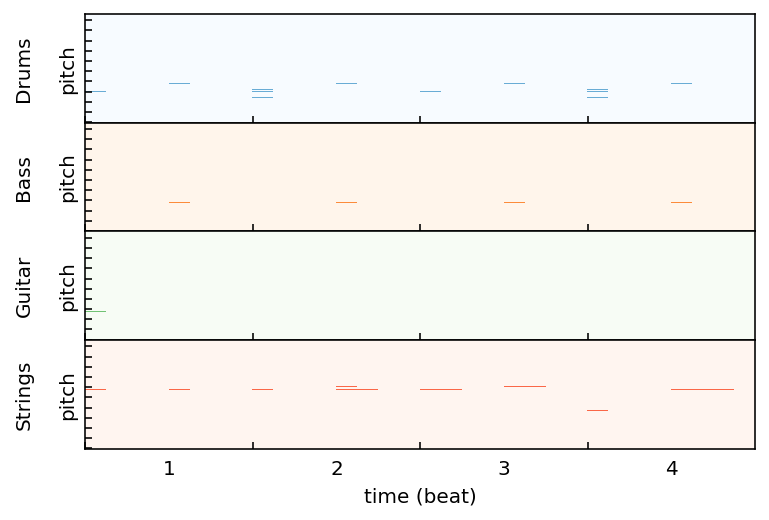

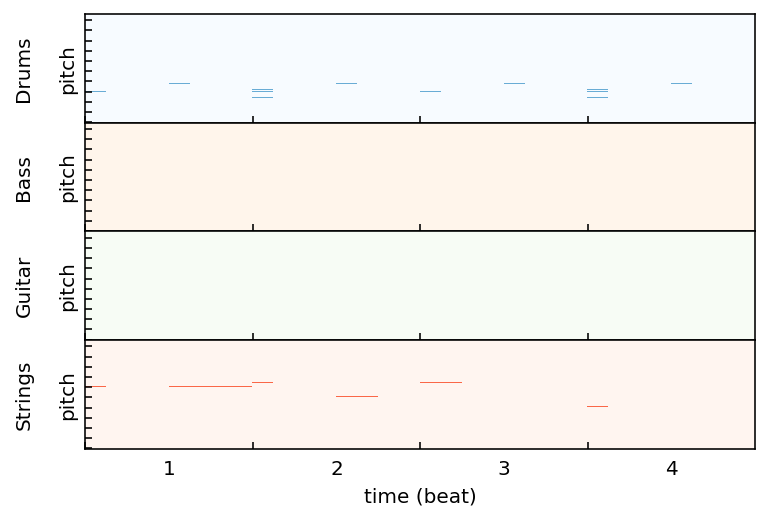

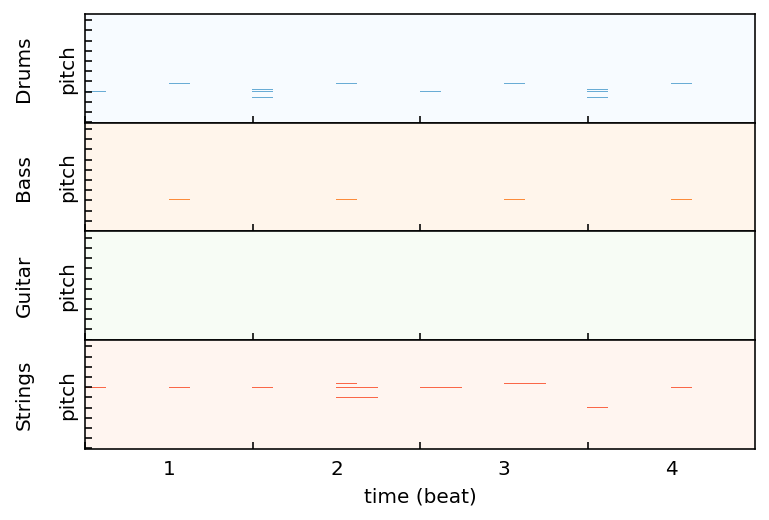

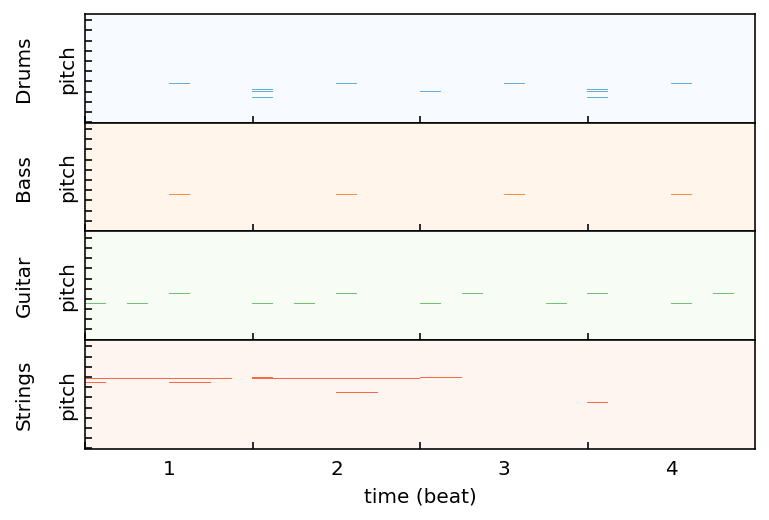

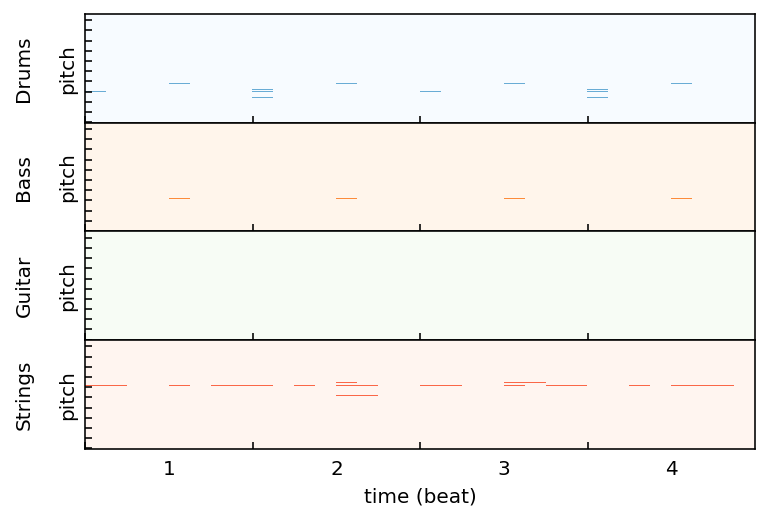

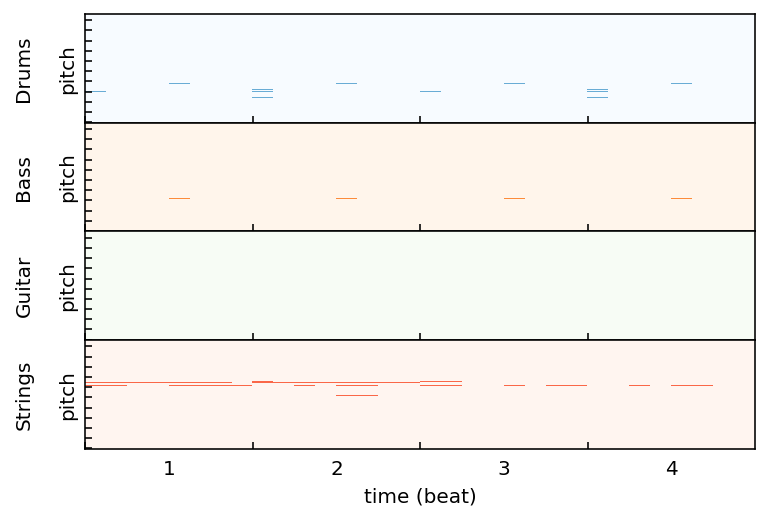

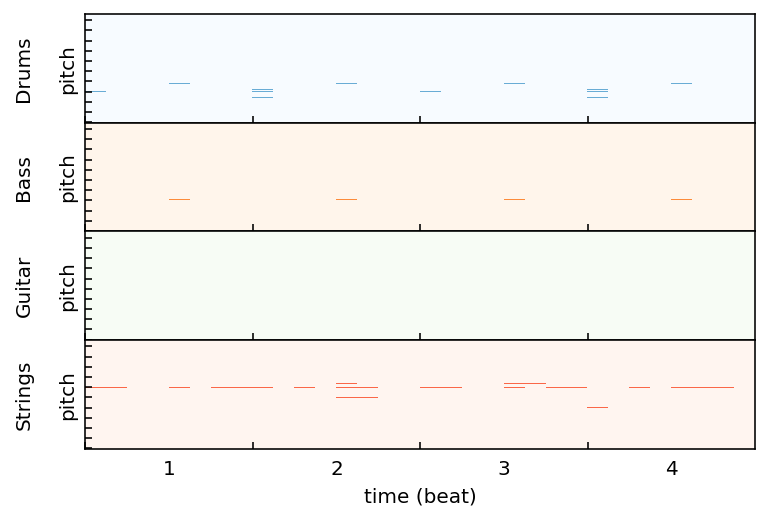

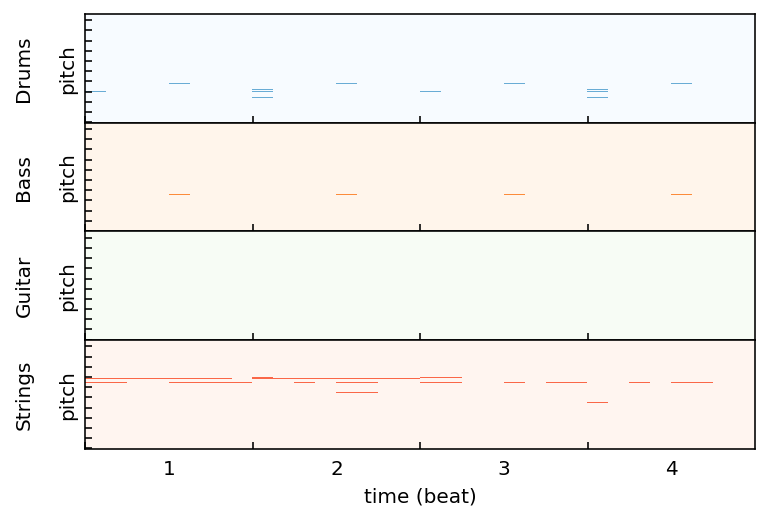

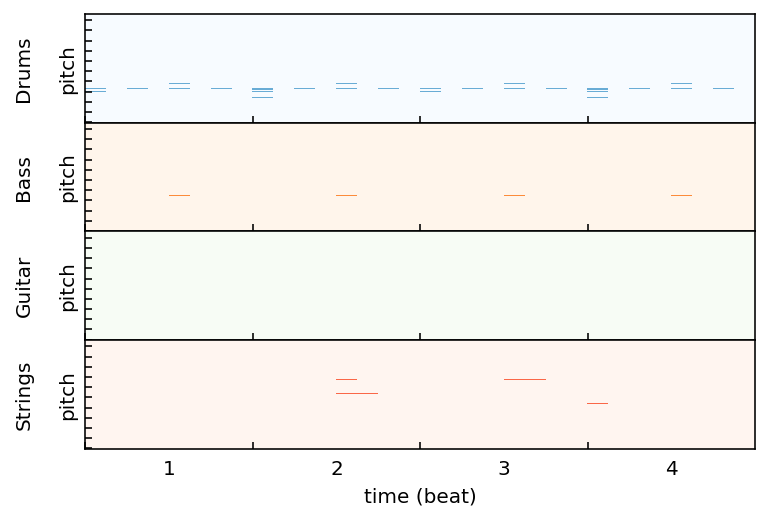

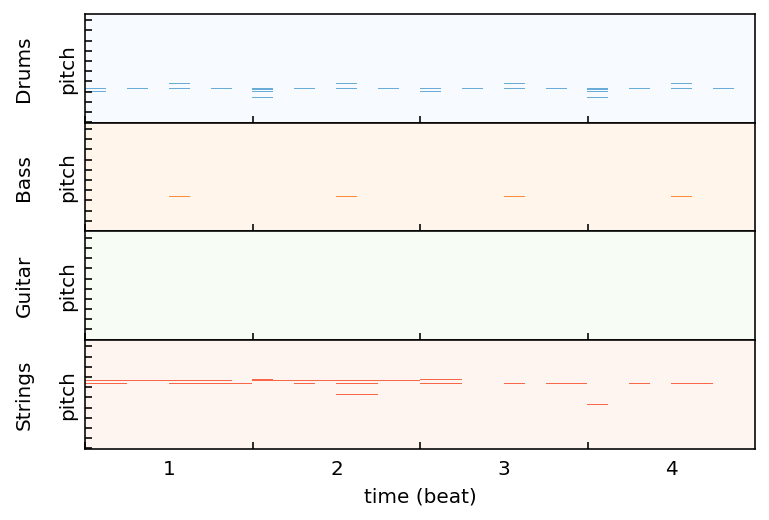

In [88]:
#tracks = [drum_track, bass_track, guitar_track, strings_track]
import copy

def from_tensor_to_muspy(music_tensor, track_data):
    
    powers = torch.tensor([2**n for n in reversed(range(9))], dtype=torch.float)
    tracks = []
    
    for tr in range(music_tensor.size(0)):
        
        notes = []
        
        for ts in range(music_tensor.size(1)):
            for note in range(music_tensor.size(2)):
                
                pitch = music_tensor[tr, ts, note, :131]
                pitch = torch.argmax(pitch)

                if pitch == 129:
                    break
                
                if pitch != 128:
                    dur = music_tensor[tr, ts, note, 131:]
                    dur = torch.dot(dur, powers).long()
                    
                    notes.append(muspy.Note(ts, pitch.item(), dur.item(), 64))
        
        if track_data[tr][0] == 'Drums':
            track = muspy.Track(name='Drums', is_drum=True, notes=copy.deepcopy(notes))
        else:
            track = muspy.Track(name=track_data[tr][0], 
                                program=track_data[tr][1],
                                notes=copy.deepcopy(notes))
        tracks.append(track)
    
    meta = muspy.Metadata(title='prova')
    music = muspy.Music(tracks=tracks, metadata=meta, resolution=RESOLUTION)
    
    return music


track_data = [('Drums', -1), ('Bass', 34), ('Guitar', 1), ('Strings', 41)]

prefix = "data/music/file"

for i in range(10):
    music_tensor = dataset[20+i][0]
    music = from_tensor_to_muspy(music_tensor, track_data)
    muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
    plt.savefig(prefix + str(i) + ".png")
    muspy.write_midi(prefix + str(i) + ".mid", music)

In [58]:
music

Music(metadata=Metadata(schema_version='0.1', title='prova'), resolution=32, tracks=[Track(program=0, is_drum=True, name='Drums', notes=[Note(time=0, pitch=45, duration=1, velocity=64), Note(time=8, pitch=45, duration=1, velocity=64), Note(time=16, pitch=45, duration=1, velocity=64), ...]), Track(program=34, is_drum=False, name='Bass', notes=[Note(time=0, pitch=30, duration=23, velocity=64), Note(time=23, pitch=32, duration=23, velocity=64), Note(time=47, pitch=32, duration=29, velocity=64)]), Track(program=1, is_drum=False, name='Guitar', notes=[Note(time=32, pitch=94, duration=5, velocity=64), Note(time=40, pitch=94, duration=5, velocity=64), Note(time=48, pitch=94, duration=5, velocity=64), ...]), ...])

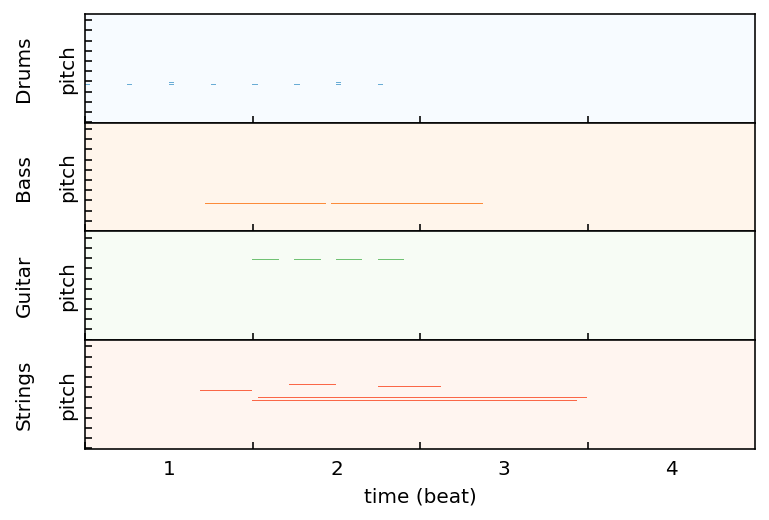

In [60]:
music_path = "data/music/file2.mid"
muspy.show_pianoroll(music, yticklabel='off', grid_axis='off')
plt.savefig('file2.png')
muspy.write_midi(music_path, music)

In [ ]:
print(dataset[0][0].size())
notes = []
notes.append(muspy.Note(1, 48, 20, 64))
drums = muspy.Track(is_drum=True)
bass = muspy.Track(program=34, notes=notes)
guitar = muspy.Track(program=27, notes=[])
strings = muspy.Track(program=42, notes=[muspy.Note(0, 100, 4, 64), muspy.Note(4, 91, 20, 64)])

tracks = [drums, bass, guitar, strings]

meta = muspy.Metadata(title='prova')
music = muspy.Music(tracks=tracks, metadata=meta, resolution=32)

In [91]:
!ls data/lmd_matched/M/T/O/TRMTOBP128E07822EF/63edabc86c087f07eca448b0edad53c3.mid

63edabc86c087f07eca448b0edad53c3.mid


# Stuff

In [ ]:
from typing import Optional, Union, Tuple
from torch_geometric.typing import OptTensor, Adj

import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import Parameter as Param
from torch.nn import Parameter
from torch_scatter import scatter
from torch_sparse import SparseTensor, matmul, masked_select_nnz
from torch_geometric.nn.conv import MessagePassing

from torch_geometric.nn.inits import glorot, zeros


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (Tensor, Tensor) -> Tensor
    pass


@torch.jit._overload
def masked_edge_index(edge_index, edge_mask):
    # type: (SparseTensor, Tensor) -> SparseTensor
    pass


def masked_edge_index(edge_index, edge_mask):
    if isinstance(edge_index, Tensor):
        return edge_index[:, edge_mask]
    else:
        return masked_select_nnz(edge_index, edge_mask, layout='coo')


class RGCNConv(MessagePassing):
    r"""The relational graph convolutional operator from the `"Modeling
    Relational Data with Graph Convolutional Networks"
    <https://arxiv.org/abs/1703.06103>`_ paper

    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta}_{\textrm{root}} \cdot
        \mathbf{x}_i + \sum_{r \in \mathcal{R}} \sum_{j \in \mathcal{N}_r(i)}
        \frac{1}{|\mathcal{N}_r(i)|} \mathbf{\Theta}_r \cdot \mathbf{x}_j,

    where :math:`\mathcal{R}` denotes the set of relations, *i.e.* edge types.
    Edge type needs to be a one-dimensional :obj:`torch.long` tensor which
    stores a relation identifier
    :math:`\in \{ 0, \ldots, |\mathcal{R}| - 1\}` for each edge.

    .. note::
        This implementation is as memory-efficient as possible by iterating
        over each individual relation type.
        Therefore, it may result in low GPU utilization in case the graph has a
        large number of relations.
        As an alternative approach, :class:`FastRGCNConv` does not iterate over
        each individual type, but may consume a large amount of memory to
        compensate.
        We advise to check out both implementations to see which one fits your
        needs.

    Args:
        in_channels (int or tuple): Size of each input sample. A tuple
            corresponds to the sizes of source and target dimensionalities.
            In case no input features are given, this argument should
            correspond to the number of nodes in your graph.
        out_channels (int): Size of each output sample.
        num_relations (int): Number of relations.
        num_bases (int, optional): If set to not :obj:`None`, this layer will
            use the basis-decomposition regularization scheme where
            :obj:`num_bases` denotes the number of bases to use.
            (default: :obj:`None`)
        num_blocks (int, optional): If set to not :obj:`None`, this layer will
            use the block-diagonal-decomposition regularization scheme where
            :obj:`num_blocks` denotes the number of blocks to use.
            (default: :obj:`None`)
        aggr (string, optional): The aggregation scheme to use
            (:obj:`"add"`, :obj:`"mean"`, :obj:`"max"`).
            (default: :obj:`"mean"`)
        root_weight (bool, optional): If set to :obj:`False`, the layer will
            not add transformed root node features to the output.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        num_relations: int,
        num_bases: Optional[int] = None,
        num_blocks: Optional[int] = None,
        aggr: str = 'mean',
        root_weight: bool = True,
        bias: bool = True,
        **kwargs,
    ):
        super().__init__(aggr=aggr, node_dim=0, **kwargs)

        if num_bases is not None and num_blocks is not None:
            raise ValueError('Can not apply both basis-decomposition and '
                             'block-diagonal-decomposition at the same time.')

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_relations = num_relations
        self.num_bases = num_bases
        self.num_blocks = num_blocks

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)
        self.in_channels_l = in_channels[0]

        if num_bases is not None:
            self.weight = Parameter(
                torch.Tensor(num_bases, in_channels[0], out_channels))
            self.comp = Parameter(torch.Tensor(num_relations, num_bases))

        elif num_blocks is not None:
            assert (in_channels[0] % num_blocks == 0
                    and out_channels % num_blocks == 0)
            self.weight = Parameter(
                torch.Tensor(num_relations, num_blocks,
                             in_channels[0] // num_blocks,
                             out_channels // num_blocks))
            self.register_parameter('comp', None)

        else:
            self.weight = Parameter(
                torch.Tensor(num_relations, in_channels[0], out_channels))
            self.register_parameter('comp', None)

        if root_weight:
            self.root = Param(torch.Tensor(in_channels[1], out_channels))
        else:
            self.register_parameter('root', None)

        if bias:
            self.bias = Param(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.comp)
        glorot(self.root)
        zeros(self.bias)


    def forward(self, x: Union[OptTensor, Tuple[OptTensor, Tensor]],
                edge_index: Adj, edge_type: OptTensor = None):
        r"""
        Args:
            x: The input node features. Can be either a :obj:`[num_nodes,
                in_channels]` node feature matrix, or an optional
                one-dimensional node index tensor (in which case input features
                are treated as trainable node embeddings).
                Furthermore, :obj:`x` can be of type :obj:`tuple` denoting
                source and destination node features.
            edge_type: The one-dimensional relation type/index for each edge in
                :obj:`edge_index`.
                Should be only :obj:`None` in case :obj:`edge_index` is of type
                :class:`torch_sparse.tensor.SparseTensor`.
                (default: :obj:`None`)
        """

        # Convert input features to a pair of node features or node indices.
        x_l: OptTensor = None
        if isinstance(x, tuple):
            x_l = x[0]
        else:
            x_l = x
        if x_l is None:
            x_l = torch.arange(self.in_channels_l, device=self.weight.device)

        x_r: Tensor = x_l
        if isinstance(x, tuple):
            x_r = x[1]

        size = (x_l.size(0), x_r.size(0))

        if isinstance(edge_index, SparseTensor):
            edge_type = edge_index.storage.value()
        assert edge_type is not None

        # propagate_type: (x: Tensor)
        out = torch.zeros(x_r.size(0), self.out_channels, device=x_r.device)

        weight = self.weight
        if self.num_bases is not None:  # Basis-decomposition =================
            weight = (self.comp @ weight.view(self.num_bases, -1)).view(
                self.num_relations, self.in_channels_l, self.out_channels)

        if self.num_blocks is not None:  # Block-diagonal-decomposition =====

            if x_l.dtype == torch.long and self.num_blocks is not None:
                raise ValueError('Block-diagonal decomposition not supported '
                                 'for non-continuous input features.')

            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)
                h = self.propagate(tmp, x=x_l, size=size)
                h = h.view(-1, weight.size(1), weight.size(2))
                h = torch.einsum('abc,bcd->abd', h, weight[i])
                out += h.contiguous().view(-1, self.out_channels)

        else:  # No regularization/Basis-decomposition ========================
            for i in range(self.num_relations):
                tmp = masked_edge_index(edge_index, edge_type == i)

                if x_l.dtype == torch.long:
                    out += self.propagate(tmp, x=weight[i, x_l], size=size)
                else:
                    h = self.propagate(tmp, x=x_l, size=size)
                    out = out + (h @ weight[i])

        root = self.root
        if root is not None:
            out += root[x_r] if x_r.dtype == torch.long else x_r @ root

        if self.bias is not None:
            out += self.bias

        return out


    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        adj_t = adj_t.set_value(None, layout=None)
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, num_relations={self.num_relations})')

next edges

In [ ]:
import itertools

a = np.random.randint(2, size=(4,8))
a_t = a.transpose()
print(a_t)
inds = np.stack(np.where(a_t == 1)).transpose()
ts_acts = np.any(a_t, axis=1)
ts_inds = np.where(ts_acts)[0]

labels = np.arange(32).reshape(4, 8).transpose()
print(labels)

next_edges = []
for i in range(len(ts_inds)-1):
    ind_s = ts_inds[i]
    ind_e = ts_inds[i+1]
    s = inds[inds[:,0] == ind_s]
    e = inds[inds[:,0] == ind_e]
    e_inds = [t for t in list(itertools.product(s, e)) if t[0][1] != t[1][1]]
    edges = [(labels[tuple(e[0])],labels[tuple(e[1])], ind_e-ind_s) for e in e_inds]
    next_edges.extend(edges)

print(next_edges)
    

onset edges

In [ ]:
onset_edges = []
print(a_t)
print(labels)

for i in ts_inds:
    ts_acts_inds = list(inds[inds[:,0] == i])
    if len(ts_acts_inds) < 2:
        continue
    e_inds = list(itertools.combinations(ts_acts_inds, 2))
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], 0) for e in e_inds]
    inv_edges = [(e[1], e[0], *e[2:]) for e in edges]
    onset_edges.extend(edges)
    onset_edges.extend(inv_edges)

print(onset_edges)


track edges

In [ ]:
print(a_t)
print(labels)
track_edges = []

for track in range(a_t.shape[1]):
    tr_inds = list(inds[inds[:,1] == track])
    e_inds = [(tr_inds[i],
               tr_inds[i+1]) for i in range(len(tr_inds)-1)]
    print(e_inds)
    edges = [(labels[tuple(e[0])], labels[tuple(e[1])], e[1][0]-e[0][0]) for e in e_inds]
    track_edges.extend(edges)

print(track_edges)

In [ ]:
track_edges = np.array(track_edges)
onset_edges = np.array(onset_edges)
np.concatenate((track_edges, onset_edges)).shape

In [ ]:
pip install pypianoroll

In [ ]:
import pypianoroll

In [ ]:
multitrack = pypianoroll.read("tests_fur-elise.mid")
print(multitrack)

In [ ]:
multitrack.tracks[0].pianoroll

In [ ]:
multitrack.plot()

In [ ]:
multitrack.trim(0, 12 * multitrack.resolution)
multitrack.binarize()

In [ ]:
multitrack.plot()

In [ ]:
multitrack.tracks[0].pianoroll.shape